<a href="https://colab.research.google.com/github/tinayiluo0322/XAI_Projects/blob/main/Explainable_ML_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #06
### Explainable ML II
### Luopeiwen Yi


## Introduction

In this notebook, we will be exploring a heart disease dataset to analyze and predict the likelihood of heart disease in patients using interpretable machine learning models. The dataset, which comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease) and [Kaggle](https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci), contains 1025 observations and 14 features, including attributes such as age, cholesterol levels, and exercise-induced angina. The goal is to predict the presence or absence of heart disease based on these medical indicators.

We will use this dataset to generate **PDP**, **ICE**, and **ALE** plots to better understand how each feature impacts the predictions of our model. Additionally, we will conduct exploratory analysis to assess the correlation between features and its influence on the results.

Throughout the notebook, we will provide comprehensive explanations of the plots, highlight any notable patterns or findings, and compare the differences between PDP and ALE plots. We will also discuss the impact of feature correlations and how it affects our interpretations.

In [35]:
import os

# Remove Colab default sample_data if it exists
if os.path.isdir("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub repo (force re-clone if it already exists)
repo_name = "XAI_Projects"
git_path = 'https://github.com/tinayiluo0322/XAI_Projects.git'

if os.path.isdir(repo_name):
    !rm -rf "{repo_name}"
!git clone "{git_path}"

# Install dependencies from requirements.txt if it exists
#requirements_file = os.path.join(repo_name, 'requirements.txt')
#if os.path.isfile(requirements_file):
    #!pip install -r "{requirements_file}"
#else:
    #print("No requirements.txt found, skipping dependency installation.")

# Change working directory to location of notebook
notebook_dir = 'Explainable_ML_II'
path_to_notebook = os.path.join(repo_name, notebook_dir)

# Check if the directory exists
if os.path.isdir(path_to_notebook):
    %cd "{path_to_notebook}"
    %ls
else:
    print(f"Directory {path_to_notebook} not found")

Cloning into 'XAI_Projects'...
remote: Enumerating objects: 6120, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 6120 (delta 18), reused 6 (delta 6), pack-reused 6078 (from 1)
Receiving objects: 100% (6120/6120), 107.96 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (5020/5020), done.
/content/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II
HeartDiseaseTrain-Test.csv  placeholder


In [36]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-93omgi0a/alepython_75502a15c5034d9888d4b9e11e07f53f
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-93omgi0a/alepython_75502a15c5034d9888d4b9e11e07f53f
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [37]:
# Models
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

np.random.seed(42)

## Exploratory Data Analysis (EDA)


14 attributes per observation in the dataset:

      1. age: age in years  

      2. sex:
         - male
         - female

      3. chest_pain_type:
        - typical angina
        - atypical angina
        - non-anginal pain
        - asymptomatic   

      4. resting_blood_pressure: (in mm Hg on admission to the hospital)

      5. cholestoral: serum cholestoral in mg/dl    

      6. fasting_blood_sugar:
        - Lower than 120 mg/ml
        - Greater than 120 mg/ml

      7. rest_ecg: resting electrocardiographic results
        - Normal
        - ST-T wave abnormality
        - Left ventricular hypertrophy

      8. Max_heart_rate: maximum heart rate achieved

      9. exercise_induced_angina
        - Yes
        - No

      10. oldpeak: ST depression induced by exercise relative to rest

      11. slope: the slope of the peak exercise ST segment
        -- Upsloping
        -- Flat
        -- Downsloping    

      12. vessels_colored_by_flourosopy: number of major vessels (0-3) colored by flourosopy  
        - Zero
        - One
        - Two
        - Three
        - Four

      13. thalassemia:
        - Normal
        - Fixed defect
        - Reversable Defect  
        - No

      14. target: (the predicted attribute) diagnosis of heart disease (angiographic disease status)
        - 0 (No)
        - 1 (Yes)

In [38]:
# URL for the dataset
url = "https://raw.githubusercontent.com/tinayiluo0322/XAI_Projects/refs/heads/main/Interpretable_ML_II/HeartDiseaseTrain-Test.csv"

# Reading the CSV file from the URL and transforming it into a pandas dataframe
df = pd.read_csv(url)

# Displaying the first few rows of the dataframe
df.head()

age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1                     Yes      3.1    Upsloping                          Zero   
2                     Yes      2.6    Upsloping                          Zero   
3                      No      0.0  Downsloping                           One   
4                      No      1.9         Flat                         Three   

         thalassemia  target  
0  Reversable Defect       0  
1  Reversable Defect       0  
2  Reversable Defect       0  
3  Reversable Defect       0  
4       Fixed Defect       0

In [39]:
# Print out the number of observations and columns
print(f'The dataset contains {df.shape[0]} observations and {df.shape[1]} columns.')

The dataset contains 1025 observations and 14 columns.


In [40]:
# Check for missing values across the entire dataframe
def check_missing_values(df):
    missing_cols = df.columns[df.isna().any()]  # Find columns with any missing values
    if len(missing_cols) > 0:
        print(f'Missing values found in the following columns:\n')
        for column in missing_cols:
            missing_rows = df[df[column].isna()]
            print(f'Column: {column}')
            print(f'Total missing values: {missing_rows.shape[0]}')
            print(f'Rows with missing values in {column}: {missing_rows.index.to_list()}')
            print('-' * 50)
    else:
        print('No missing values found in the dataset.')

# Apply the check on the entire dataframe
check_missing_values(df)

No missing values found in the dataset.


In [41]:
# Set the list of categorical variables and continous variables in the dataset
categorical_vars = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
continuous_vars = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

Exploring categorical variable: sex
sex
Male      713
Female    312
Name: count, dtype: int64


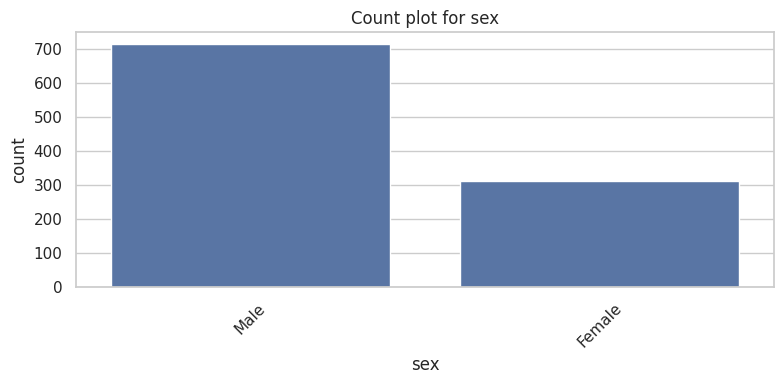

Exploring categorical variable: chest_pain_type
chest_pain_type
Typical angina      497
Non-anginal pain    284
Atypical angina     167
Asymptomatic         77
Name: count, dtype: int64


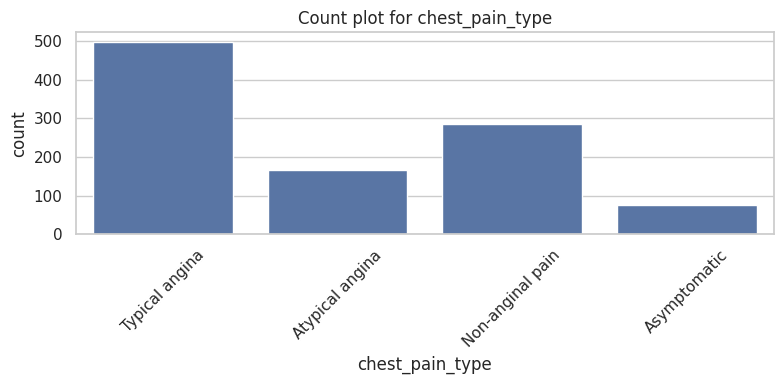

Exploring categorical variable: fasting_blood_sugar
fasting_blood_sugar
Lower than 120 mg/ml      872
Greater than 120 mg/ml    153
Name: count, dtype: int64


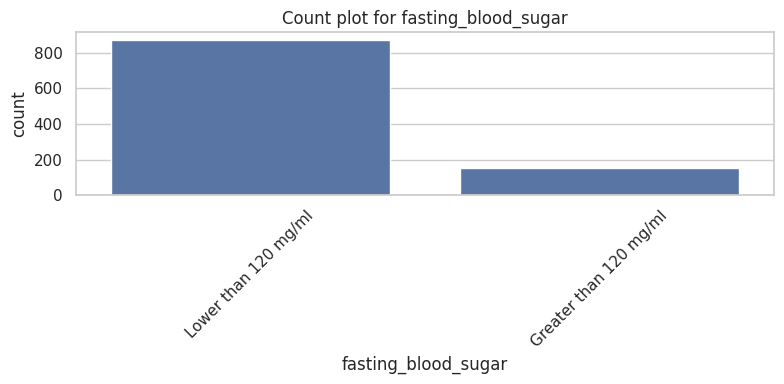

Exploring categorical variable: rest_ecg
rest_ecg
ST-T wave abnormality           513
Normal                          497
Left ventricular hypertrophy     15
Name: count, dtype: int64


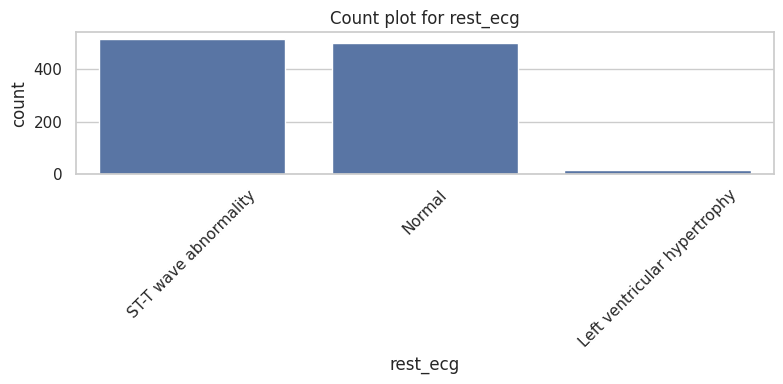

Exploring categorical variable: exercise_induced_angina
exercise_induced_angina
No     680
Yes    345
Name: count, dtype: int64


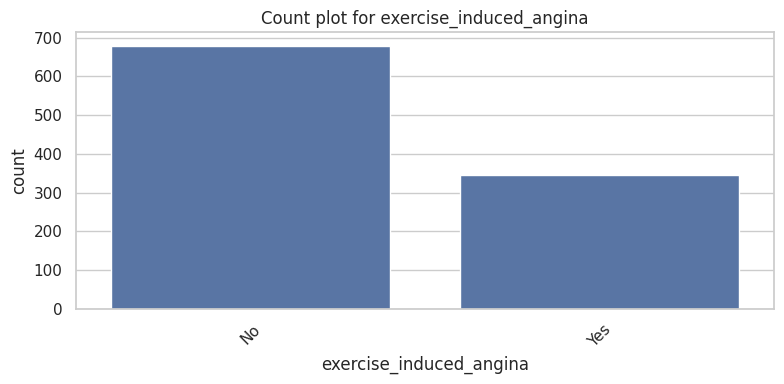

Exploring categorical variable: slope
slope
Flat           482
Downsloping    469
Upsloping       74
Name: count, dtype: int64


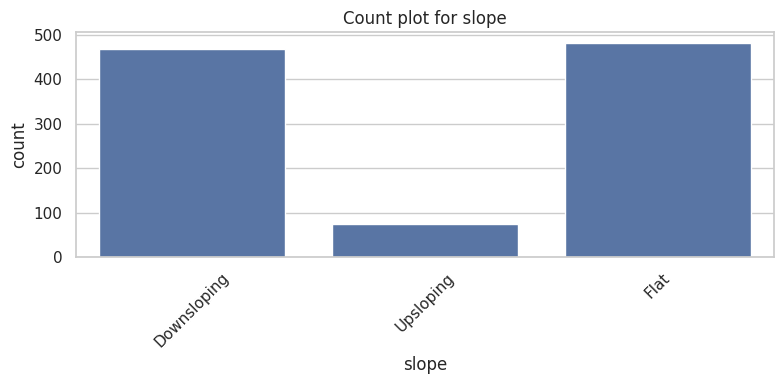

Exploring categorical variable: vessels_colored_by_flourosopy
vessels_colored_by_flourosopy
Zero     578
One      226
Two      134
Three     69
Four      18
Name: count, dtype: int64


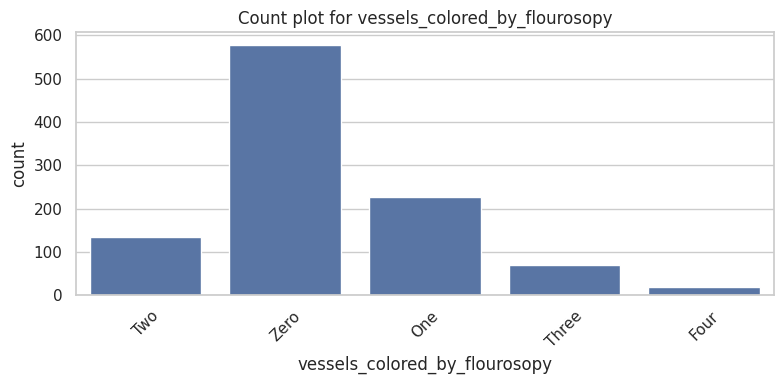

Exploring categorical variable: thalassemia
thalassemia
Fixed Defect         544
Reversable Defect    410
Normal                64
No                     7
Name: count, dtype: int64


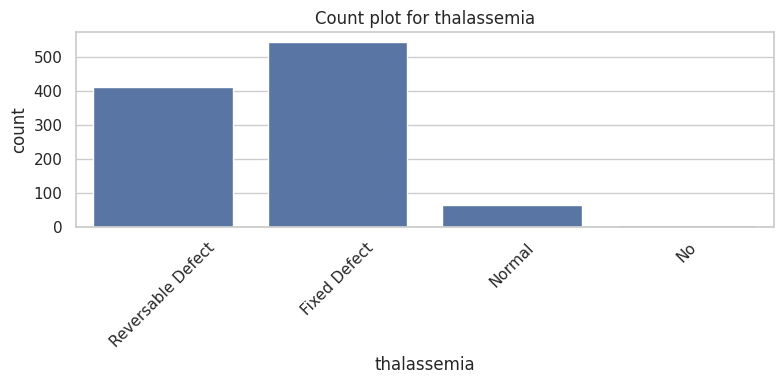


Exploring continuous variable: age


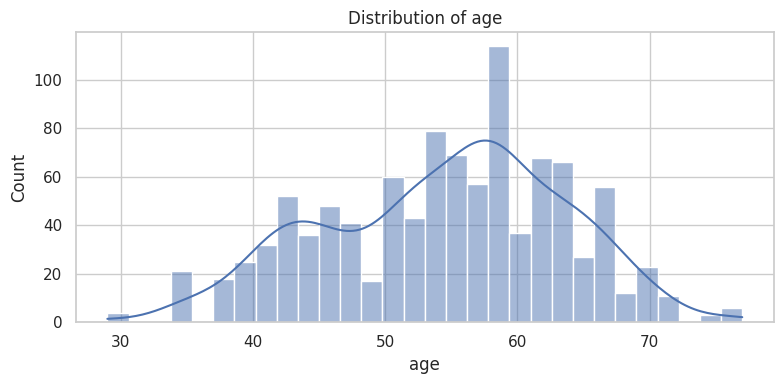


Exploring continuous variable: resting_blood_pressure


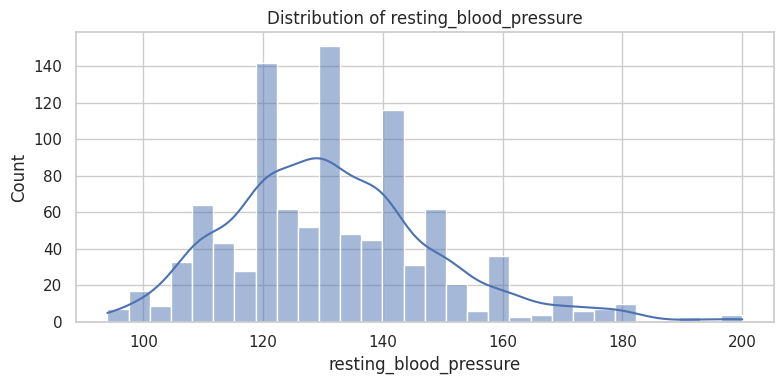


Exploring continuous variable: cholestoral


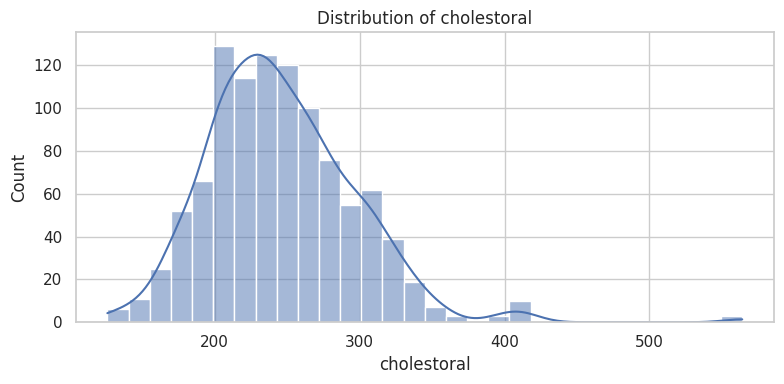


Exploring continuous variable: Max_heart_rate


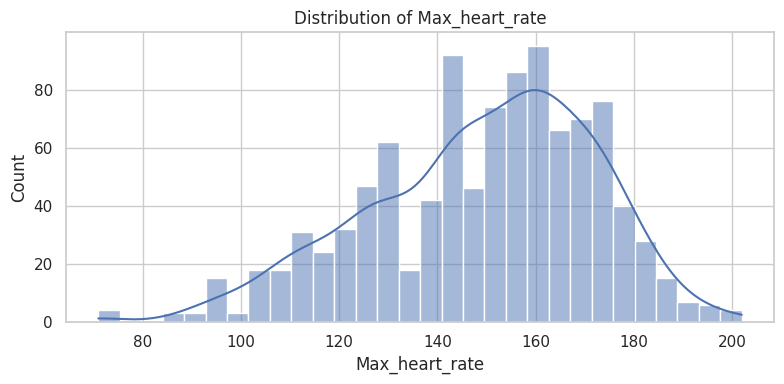


Exploring continuous variable: oldpeak


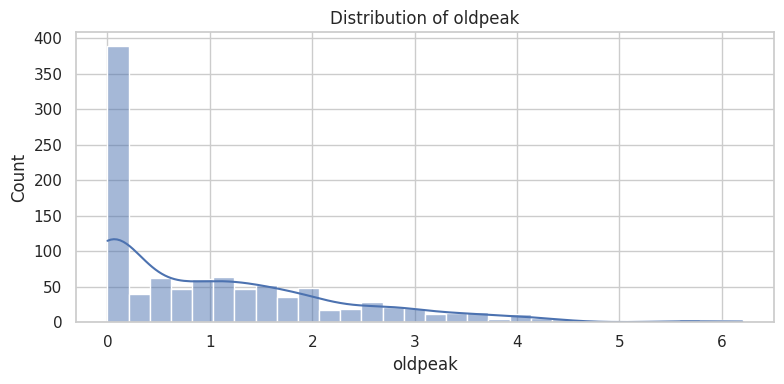

Exploring target outcome variable: Heart Disease
target
1    526
0    499
Name: count, dtype: int64


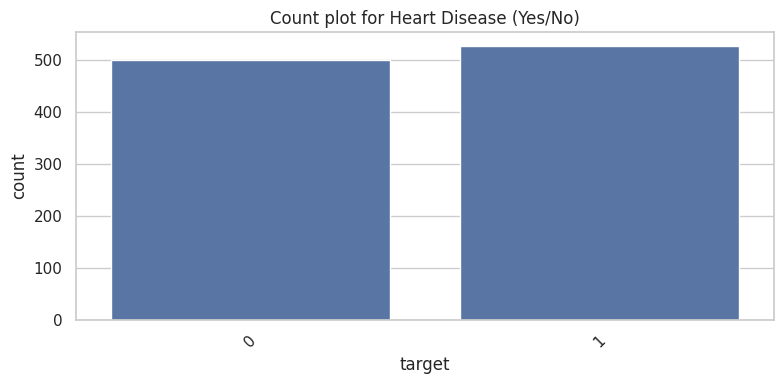

In [42]:
# Set plot style for consistent visualization
sns.set(style="whitegrid")

# Exploring categorical variables
for var in categorical_vars:
    print(f"Exploring categorical variable: {var}")
    print(df[var].value_counts())
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=var)
    plt.title(f'Count plot for {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exploring continuous variables
for var in continuous_vars:
    print(f"\nExploring continuous variable: {var}")
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

# Exploring target outcome variable (Heart Disease)
print("Exploring target outcome variable: Heart Disease")
print(df['target'].value_counts())
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='target')
plt.title('Count plot for Heart Disease (Yes/No)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [43]:
# One-hot encode the categorical variables, excluding the target variable
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

In [44]:
# print the columns from the one hot encouded data frame
df_encoded.columns

Index(['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate',
       'oldpeak', 'target', 'sex_Male', 'chest_pain_type_Atypical angina',
       'chest_pain_type_Non-anginal pain', 'chest_pain_type_Typical angina',
       'fasting_blood_sugar_Lower than 120 mg/ml', 'rest_ecg_Normal',
       'rest_ecg_ST-T wave abnormality', 'exercise_induced_angina_Yes',
       'slope_Flat', 'slope_Upsloping', 'vessels_colored_by_flourosopy_One',
       'vessels_colored_by_flourosopy_Three',
       'vessels_colored_by_flourosopy_Two',
       'vessels_colored_by_flourosopy_Zero', 'thalassemia_No',
       'thalassemia_Normal', 'thalassemia_Reversable Defect'],
      dtype='object')

In [45]:
# define predictor and target variables
X = df_encoded.drop(columns=['target'])
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Correlation Checking

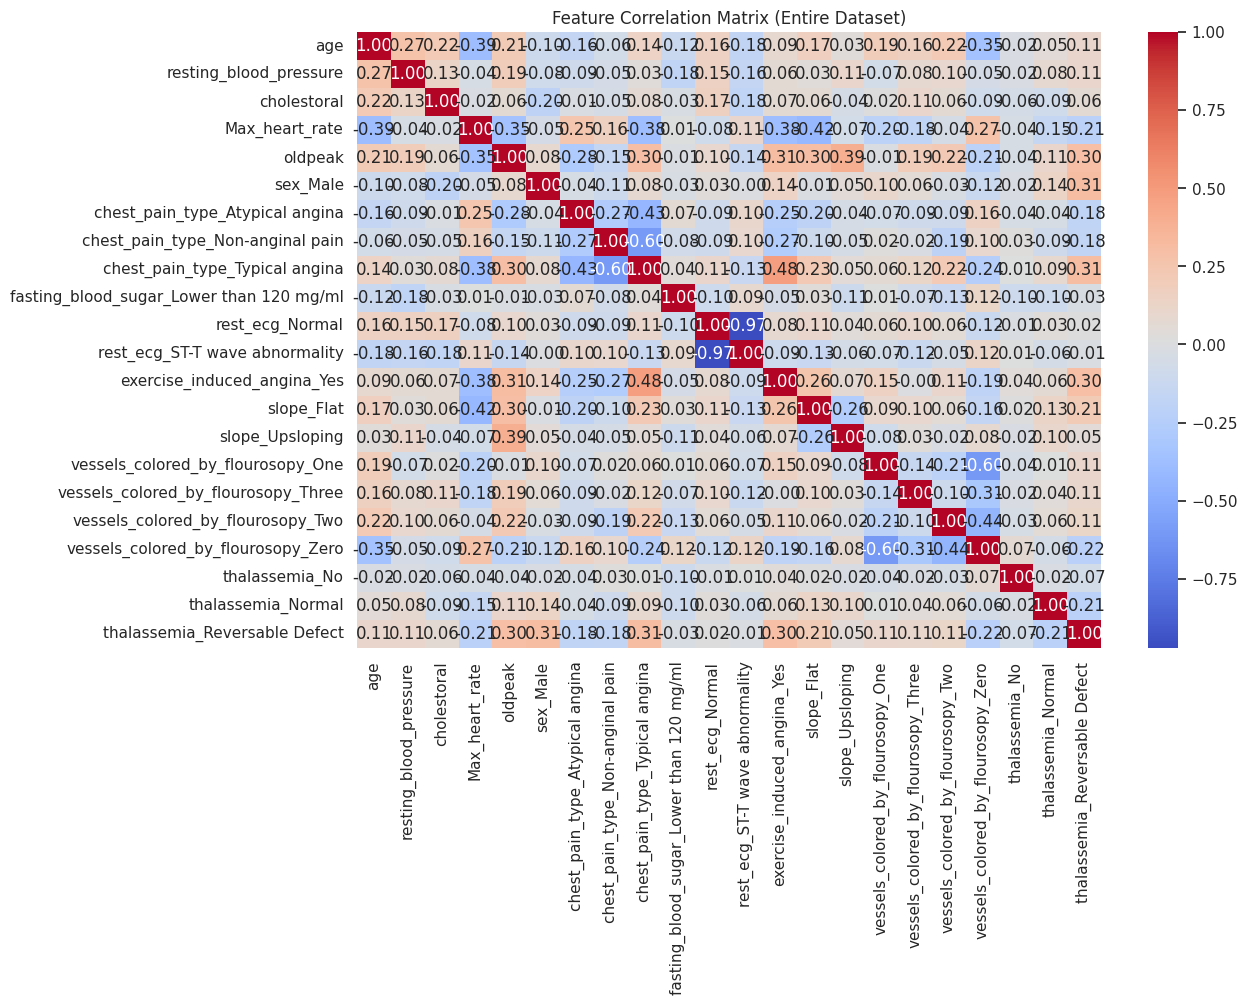

In [46]:
# Calculate the correlation matrix for the entire dataset
corr_matrix = X.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix (Entire Dataset)')
plt.show()

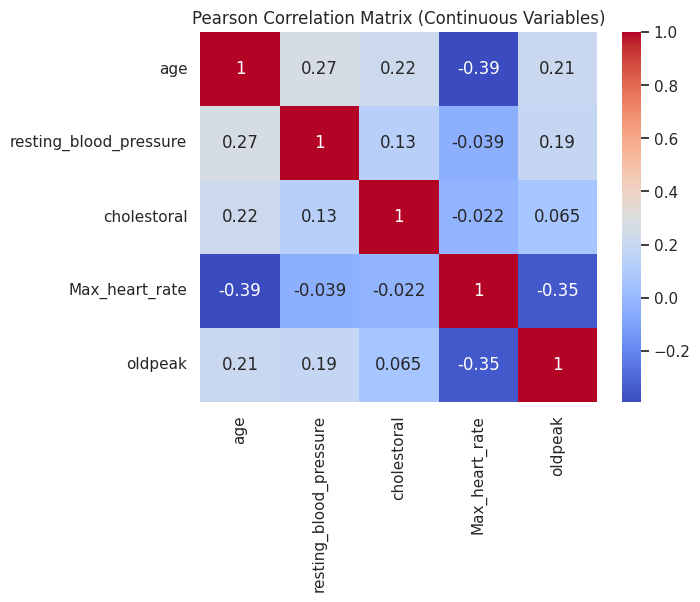

In [47]:
# Pearson correlation matrix for continuous variables
corr_matrix_cont = df_encoded[continuous_vars].corr(method='pearson')
sns.heatmap(corr_matrix_cont, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix (Continuous Variables)')
plt.show()

In [48]:
# Check for missing or infinite values
print(X.isnull().sum())  # Check for NaNs
print(X[~X.applymap(np.isfinite)].dropna())  # Check for infinite values

age                                         0
resting_blood_pressure                      0
cholestoral                                 0
Max_heart_rate                              0
oldpeak                                     0
sex_Male                                    0
chest_pain_type_Atypical angina             0
chest_pain_type_Non-anginal pain            0
chest_pain_type_Typical angina              0
fasting_blood_sugar_Lower than 120 mg/ml    0
rest_ecg_Normal                             0
rest_ecg_ST-T wave abnormality              0
exercise_induced_angina_Yes                 0
slope_Flat                                  0
slope_Upsloping                             0
vessels_colored_by_flourosopy_One           0
vessels_colored_by_flourosopy_Three         0
vessels_colored_by_flourosopy_Two           0
vessels_colored_by_flourosopy_Zero          0
thalassemia_No                              0
thalassemia_Normal                          0
thalassemia_Reversable Defect     

In [49]:
# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

In [50]:
# Check the data types of each column
print(X.dtypes)

age                                           int64
resting_blood_pressure                        int64
cholestoral                                   int64
Max_heart_rate                                int64
oldpeak                                     float64
sex_Male                                       bool
chest_pain_type_Atypical angina                bool
chest_pain_type_Non-anginal pain               bool
chest_pain_type_Typical angina                 bool
fasting_blood_sugar_Lower than 120 mg/ml       bool
rest_ecg_Normal                                bool
rest_ecg_ST-T wave abnormality                 bool
exercise_induced_angina_Yes                    bool
slope_Flat                                     bool
slope_Upsloping                                bool
vessels_colored_by_flourosopy_One              bool
vessels_colored_by_flourosopy_Three            bool
vessels_colored_by_flourosopy_Two              bool
vessels_colored_by_flourosopy_Zero             bool
thalassemia_

In [51]:
# Convert boolean columns to integers
X = X.astype(int)

# Check the data types again to ensure conversion
print(X.dtypes)

age                                         int64
resting_blood_pressure                      int64
cholestoral                                 int64
Max_heart_rate                              int64
oldpeak                                     int64
sex_Male                                    int64
chest_pain_type_Atypical angina             int64
chest_pain_type_Non-anginal pain            int64
chest_pain_type_Typical angina              int64
fasting_blood_sugar_Lower than 120 mg/ml    int64
rest_ecg_Normal                             int64
rest_ecg_ST-T wave abnormality              int64
exercise_induced_angina_Yes                 int64
slope_Flat                                  int64
slope_Upsloping                             int64
vessels_colored_by_flourosopy_One           int64
vessels_colored_by_flourosopy_Three         int64
vessels_colored_by_flourosopy_Two           int64
vessels_colored_by_flourosopy_Zero          int64
thalassemia_No                              int64


In [52]:
# Compute VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF for each variable
print(vif_data)

                                     Feature        VIF
0                                        age  49.407563
1                     resting_blood_pressure  61.514465
2                                cholestoral  27.359988
3                             Max_heart_rate  54.655323
4                                    oldpeak   2.828662
5                                   sex_Male   4.258406
6            chest_pain_type_Atypical angina   3.223789
7           chest_pain_type_Non-anginal pain   4.623319
8             chest_pain_type_Typical angina   7.798969
9   fasting_blood_sugar_Lower than 120 mg/ml   7.178721
10                           rest_ecg_Normal  30.841990
11            rest_ecg_ST-T wave abnormality  31.341250
12               exercise_induced_angina_Yes   2.255830
13                                slope_Flat   2.928994
14                           slope_Upsloping   1.680824
15         vessels_colored_by_flourosopy_One  12.792043
16       vessels_colored_by_flourosopy_Three   4

**Multicollinearity Report: Variables with VIF > 10**

Multicollinearity is the occurrence of high intercorrelations among independent variables in a regression model. High multicollinearity can affect the interpretability of the model by making it difficult to determine the individual effect of each predictor. Here, we review the variables with **Variance Inflation Factor (VIF) greater than 10**, indicating strong multicollinearity and suggesting the need for further investigation or adjustments to the model.


**Variables with VIF > 10:**

| **Feature**                             | **VIF**    |
|-----------------------------------------|------------|
| Age                                     | 49.41      |
| Resting Blood Pressure                  | 61.51      |
| Cholesterol                             | 27.36      |
| Max Heart Rate                          | 54.66      |
| Resting ECG (Normal)                    | 30.84      |
| Resting ECG (ST-T wave abnormality)      | 31.34      |
| Vessels Colored by Fluoroscopy (One)    | 12.79      |
| Vessels Colored by Fluoroscopy (Zero)   | 29.97      |

The features with VIF values greater than 10, including Age (49.41), Resting Blood Pressure (61.51), Cholesterol (27.36), Max Heart Rate (54.66), Resting ECG (Normal, 30.84), Resting ECG (ST-T wave abnormality, 31.34), and Vessels Colored by Fluoroscopy (12.79, 29.97), indicate high multicollinearity in the model. This suggests that these variables are strongly correlated with other predictors, potentially leading to instability in the model and making it difficult to interpret the individual contributions of each feature.

## XGBoost Model

### Modeling

In [53]:
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [54]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9853658536585366
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



### PDP Plot

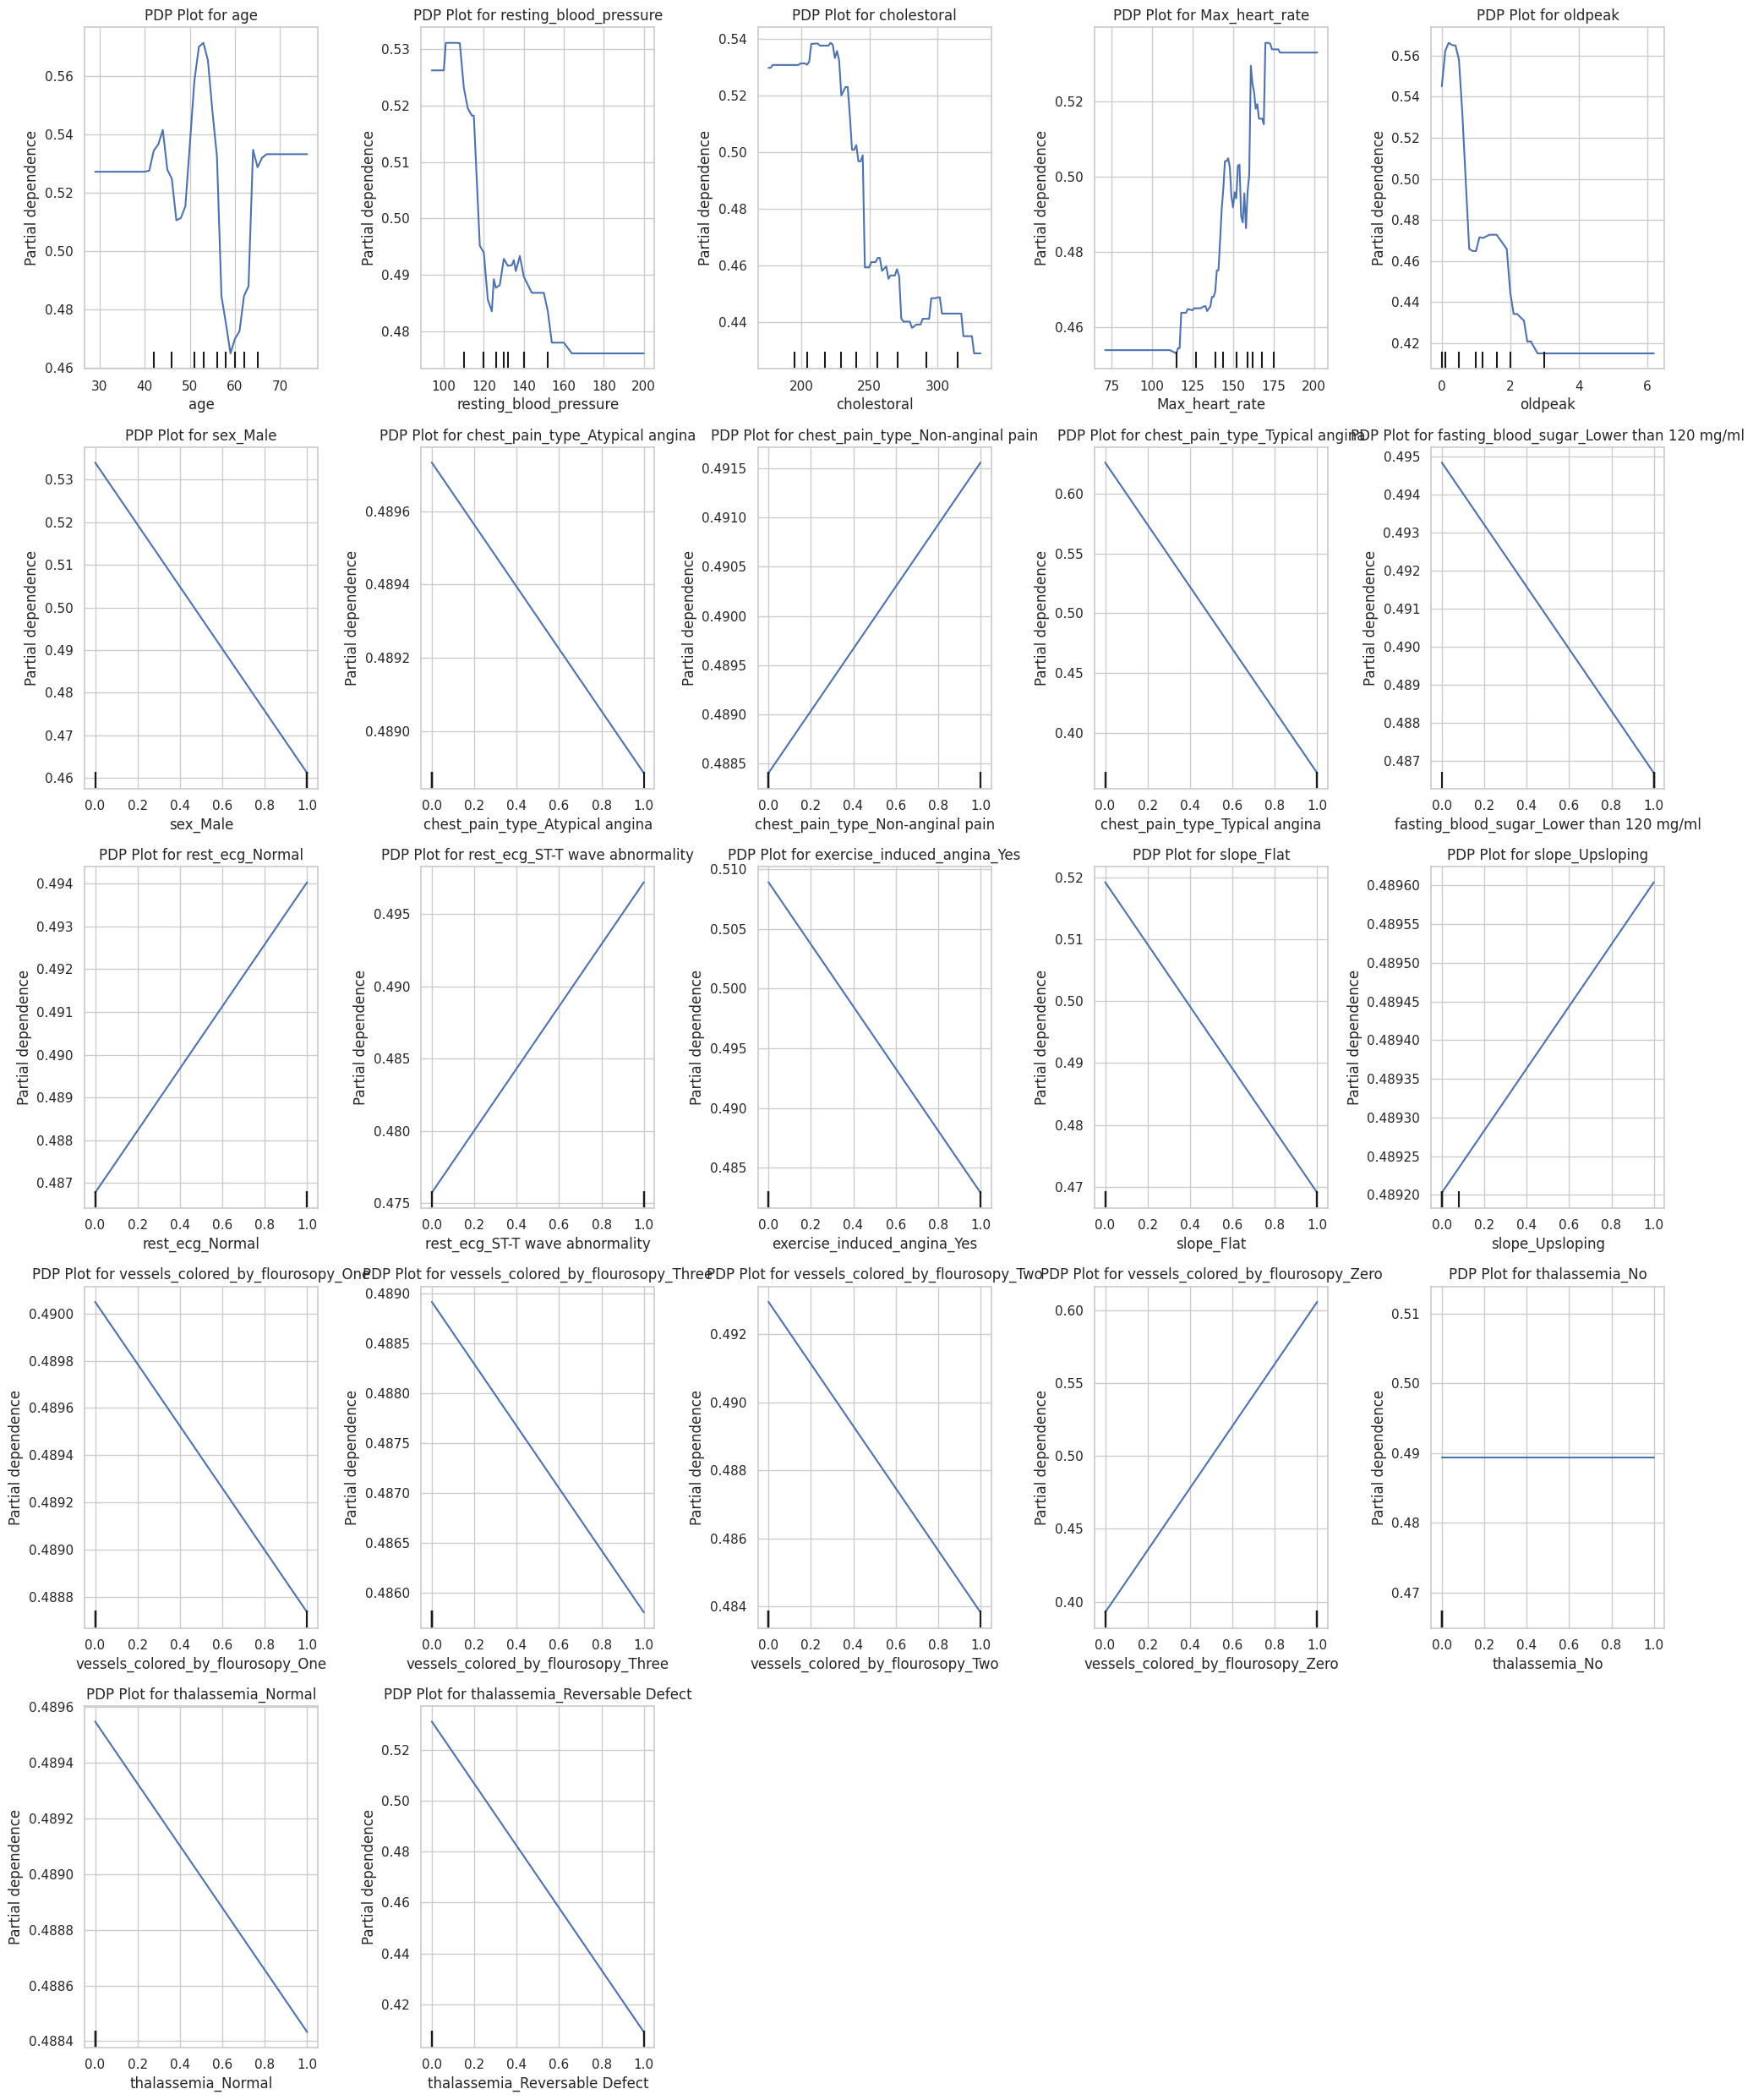

In [55]:
# List of all features in the dataset
features = X.columns.tolist()

# Set number of rows and columns for subplots
n_features = len(features)
n_cols = 5  # Set to 5 plots per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots for PDP plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Adjust figure size to fit 5 plots per row

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot PDP for each feature in a loop
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, [X.columns.get_loc(feature)], kind='average', ax=axs[i]
    )
    axs[i].set_title(f'PDP Plot for {feature}')

# Remove any empty subplots if the number of features isn't a perfect multiple of n_cols
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### **Partial Dependence Plot (PDP) Analysis**

This section provides an interpretation of the PDP plots for the 22 features used in the heart disease prediction model. We analyze the effect of each feature on the prediction by looking at the shape of the curve, whether increasing or decreasing values affect the outcome, and whether the relationship makes sense in the context of heart disease.

---
**1. Age**
- **Pattern**: Non-linear with distinct fluctuations.
- **Effect**: As age increases, the likelihood of heart disease increases from 40 to 50 with some slight fluctuations. It then drops significantly between ages 50 and 60, followed by another increase from 60 to 70.
- **Interpretation**: This pattern suggests that age is a significant factor in predicting heart disease, with key transitions in risk occurring around ages 50 and 60. The initial rise and subsequent drop may reflect an interaction with other factors such as overall health and medical intervention around these ages.

---

**2. Resting Blood Pressure**
- **Pattern**: Non-linear behavior with sharp drop after 100 and plateaus after 160.
- **Effect**: Higher resting blood pressure decreases the likelihood of heart disease, which seems counterintuitive.
- **Interpretation**: This requires further investigation, as higher blood pressure is generally associated with greater risk.

---

**3. Cholesterol**
- **Pattern**: Decrease and non-linear behavior.
- **Effect**: Increasing cholesterol lowers the predicted risk of heart disease, which is unexpected.
- **Plateau**: Flattens around 250.
- **Interpretation**: Cholesterol is a known heart disease factor, so this warrants further analysis.

---

**4. Max Heart Rate**
- **Pattern**: Non-linear with fluctuations.
- **Effect**: From 125 to 175, the max heart rate shows an overall increase in heart disease risk, though the relationship fluctuates within this range.
- **Interpretation**: While higher fitness typically correlates with a lower risk of heart disease, the fluctuations in this range suggest that max heart rate interacts with other health factors. These interactions may lead to unexpected increases in risk for some individuals, despite higher heart rates often being associated with better cardiovascular health.

---

**5. Oldpeak (ST Depression)**
- **Pattern**: Strong downward slope from 0 to 3, followed by a plateau after 3.
- **Effect**: As oldpeak increases, the likelihood of heart disease decreases sharply until it levels off after a value of 3.
- **Interpretation**: This result seems counterintuitive, as higher ST depression is typically associated with more severe heart conditions. The model may have learned unexpected relationships, and further investigation is warranted to understand why increasing oldpeak appears to decrease heart disease risk.

---

**6. Sex (Male)**
- **Pattern**: Linear, downward trend.
- **Effect**: Being male decreases heart disease likelihood, which is counterintuitive.
- **Interpretation**: Males generally have higher risk, so this result might need further investigation.

---

**7. Chest Pain Type (Atypical Angina)**
- **Pattern**: Linear, downward trend.
- **Effect**: The presence of atypical angina decreases the likelihood of heart disease.
- **Interpretation**: This result is somewhat unexpected, as atypical angina is usually associated with some degree of heart disease risk. The downward trend suggests that the model might be interpreting atypical angina as less indicative of heart disease compared to other symptoms. Further analysis could explore interactions with other features or verify whether atypical angina is underrepresented in more severe cases.

---

**8. Chest Pain Type (Non-Anginal Pain)**
- **Pattern**: Linear, upward slope.
- **Effect**: The presence of non-atypical angina increases the likelihood of heart disease.
- **Interpretation**: Non-anginal pain has an indirect relationship with heart disease.

---

**9. Chest Pain Type (Typical Angina)**
- **Pattern**: Linear, downward trend.
- **Effect**: The presence of typical angina decreases the likelihood of heart disease in this model.
- **Interpretation**: This result is counterintuitive, as typical angina is a well-known symptom strongly associated with heart disease. The decrease in risk suggests that the model may be influenced by interactions with other features, or that typical angina might be underrepresented in severe cases in this dataset. Further investigation into how this feature is used in the model is necessary.
---

**10. Fasting Blood Sugar (Lower than 120 mg/ml)**
- **Pattern**: Linear, downward slope.
- **Effect**: Fasting Blood Sugar (Lower than 120 mg/ml) decreases heart disease likelihood.
- **Interpretation**: Lower blood sugar is generally beneficial, especially given its link to diabetes.

---

**11. Rest ECG (Normal)**
- **Pattern**: Linear, upward slope.
- **Effect**: Surprisingly, a normal ECG increases risk of heart disease.
- **Interpretation**: This result is unexpected and may need further examination.

---

**12. Rest ECG (ST-T Wave Abnormality)**
- **Pattern**: Linear, upward slope.
- **Effect**: ST-T Wave Abnormality ECG increases the likelihood of heart disease.
- **Interpretation**: This aligns well with medical knowledge, as ST-T wave abnormalities often indicate heart issues.

---

**13. Exercise Induced Angina (Yes)**
- **Pattern**: Linear, downward slope.
- **Effect**: The presence of exercise-induced angina decreases the likelihood of heart disease in this model.
- **Interpretation**: This result is unexpected, as exercise-induced angina is typically associated with a higher risk of heart disease due to coronary issues. The downward trend might suggest that the model has learned complex relationships where this feature interacts with others, possibly diluting its expected impact. Further examination of these interactions is recommended.

---

**14. Slope (Flat)**
- **Pattern**: Linear, downward slope.
- **Effect**: Flat slope decreases heart disease risk.
- **Interpretation**: This is unexpected, as flat slopes generally indicate abnormal stress test results.

---

**15. Slope (Upsloping)**
- **Pattern**: Linear, upward slope.
- **Effect**: Upsloping slope increases the likelihood of heart disease.
- **Interpretation**: This result is somewhat unexpected, as an upsloping ST segment during a stress test is typically considered a normal response and usually indicates a lower risk of heart disease. The upward trend suggests that the model might be picking up on more subtle patterns or interactions where an upsloping ST segment is associated with higher risk. Further analysis of how this feature interacts with others could clarify its role.

---

**16. Vessels Colored by Fluoroscopy (One)**
- **Pattern**: Linear, downward slope.
- **Effect**: One vessel colored reduces heart disease risk.
- **Interpretation**: Fewer vessels may indicate less severe conditions.

---

**17. Vessels Colored by Fluoroscopy (Two)**
- **Pattern**: Linear, downward slope.
- **Effect**: Two vessels colored reduces heart disease risk.
- **Interpretation**: Similar to the one-vessel case, this is somewhat unexpected.

---

**18. Vessels Colored by Fluoroscopy (Three)**
- **Pattern**: Linear, downward slope.
- **Effect**: Three vessels colored reduces heart disease risk.
- **Interpretation**: This warrants further investigation to clarify the relationship.

---

**19. Vessels Colored by Fluoroscopy (Zero)**
- **Pattern**: Linear, upward slope.
- **Effect**: No vessels colored increases heart disease risk.
- **Interpretation**: This aligns with expectations, as the absence of colored vessels during fluoroscopy typically indicates more severe coronary artery issues. The upward trend suggests that patients with zero vessels colored are at higher risk of heart disease, which makes sense in the context of coronary assessments.

---

**20. Thalassemia (No)**
- **Pattern**: Flat line.
- **Effect**: No effect on the prediction.
- **Interpretation**: This feature seems irrelevant in predicting heart disease.

---

**21. Thalassemia (Normal)**
- **Pattern**: Linear, downward slope.
- **Effect**: Normal thalassemia decreases the likelihood of heart disease.
- **Interpretation**: This is aligned with the role thalassemia plays in heart conditions.

---

**22. Thalassemia (Reversible Defect)**
- **Pattern**: Linear, downward slope.
- **Effect**: Thalassemia (Reversible Defect) decreases heart disease likelihood.
- **Interpretation**: This result is unexpected, as a reversible defect in thalassemia usually implies a higher risk of complications that could contribute to heart disease. The downward slope suggests that the model has learned a relationship that does not align with medical knowledge, indicating a weak or inverse relationship. This might require further investigation into how this feature interacts with others in the dataset or whether it's underrepresented in severe cases.

### **Analysis of PDP’s Pros and Cons in the Context of Heart Disease Prediction**

Partial Dependence Plots (PDP) are widely used for interpreting the marginal effects of features in machine learning models, but they come with certain limitations, particularly when dealing with correlated features. The analysis of the PDPs for heart disease prediction reveals both the strengths and weaknesses of PDPs, especially in cases where feature correlations significantly influence the results.

---

**Pros of PDP**:

1. **Clear Interpretation (in uncorrelated cases)**:
   - PDPs offer a straightforward way to interpret how features affect the predictions by plotting the average marginal effect of each feature. When the features are uncorrelated, PDPs can give reliable insights. For instance:
     - **Fasting Blood Sugar (Lower than 120 mg/ml)**: The linear downward slope shows that lower fasting blood sugar decreases the likelihood of heart disease, which aligns with the medical understanding that lower blood sugar is beneficial, especially due to its connection with diabetes and heart disease risk. This example shows how PDPs can clearly convey the relationship between a feature and the prediction when no significant correlation exists.

2. **Ease of Implementation**:
   - PDPs are easy to compute and visualize, requiring only a few lines of code to plot the relationship between features and the model’s predictions. This makes them a popular choice for model interpretation.

---

**Cons of PDP**:

1. **Assumes Features Are Independent**:
   - **PDP assumes that features are independent**, which can lead to misleading or counterintuitive results when the features are correlated. In the heart disease model, several key features have **high Variance Inflation Factor (VIF)** scores, indicating multicollinearity:
     - **Age (VIF = 49.41)**, **Resting Blood Pressure (VIF = 61.51)**, **Cholesterol (VIF = 27.36)**, and **Max Heart Rate (VIF = 54.66)** are all highly correlated. As a result, the marginal effects shown in the PDPs may not accurately represent their true impact, because the PDP doesn't account for interactions between these features.
     - **Resting Blood Pressure** shows a **counterintuitive decrease in risk** at higher values, which contradicts medical knowledge. This could be explained by the high correlation between resting blood pressure and other features, leading PDP to incorrectly assume independence.
     - Similarly, **Cholesterol** decreases the predicted risk of heart disease, which is unexpected because cholesterol is typically a key risk factor. This misleading trend likely stems from the high correlation between cholesterol and other cardiovascular indicators.

2. **Only Shows Average Marginal Effects**:
   - PDPs display the **average** marginal effect of a feature on predictions, potentially masking important variations in how a feature interacts with others:
     - **Max Heart Rate** shows fluctuations between 125 and 175, but the overall trend suggests an increase in risk. However, this average effect might be hiding the complex interplay between heart rate and other health factors, leading to unexpected fluctuations in risk.
     - **Rest ECG (Normal)** shows a **linear upward trend**, suggesting that a normal ECG increases heart disease risk. This is counterintuitive and could be a result of interactions between normal ECG and other variables, which are averaged out by the PDP.

3. **Limited to 2 Features per Plot**:
   - PDPs can only plot one or two features at a time, which limits their ability to capture the interactions between multiple features. In models where multicollinearity and feature interactions are significant, this limitation can reduce the explanatory power of PDPs.
     - For instance, **Vessels Colored by Fluoroscopy (Zero)** shows an **upward trend**, correctly indicating higher heart disease risk, but this analysis does not account for other related factors like cholesterol and age, which might be influencing the result.

---

**How Feature Correlation and PDP Drawbacks Are Reflected in the Observed Trends**:

1. **Unexpected Trends Due to Feature Correlations**:
   - **Resting Blood Pressure** and **Cholesterol**: The unexpected **decrease in heart disease risk** for higher resting blood pressure and cholesterol levels can be attributed to feature correlation. These variables are strongly correlated with age, heart rate, and other indicators, meaning that their effects are not being independently observed by the PDP.
   - **Vessels Colored by Fluoroscopy**: The counterintuitive **downward slope** for one, two, and three vessels colored is also likely a result of the high multicollinearity between this feature and other cardiovascular indicators. PDP assumes that these features are independent, but they are highly related to each other, leading to misleading interpretations.

2. **Averaging Masks Important Variations**:
   - **Max Heart Rate**: The **fluctuations** in heart disease risk between heart rates of 125 and 175 might be caused by the averaging effect of PDP. While the average effect suggests increased risk, the fluctuations indicate that max heart rate is interacting with other health variables, which PDP does not fully capture.
   - **Rest ECG (Normal)**: The **upward slope** in risk for a normal ECG is counterintuitive, and PDP may be averaging out interactions between a normal ECG and other features, such as exercise-induced angina or cholesterol levels.

---

**Conclusion**:
While **PDPs** offer clear and easy-to-implement visualizations of feature importance, they come with significant drawbacks, especially in the presence of correlated features. The assumption of independence leads to counterintuitive trends in highly correlated variables, as seen in the **Resting Blood Pressure**, **Cholesterol**, and **Vessels Colored by Fluoroscopy** features in this heart disease model. Additionally, the averaging effect of PDP may mask important interactions between features, leading to misleading interpretations. In such cases, using alternative techniques like **Individual Conditional Expectation (ICE)** or **Accumulated Local Effects (ALE)**, which better account for feature interactions, could provide more accurate insights.


### ICE Plot


**ICE (Individual Conditional Expectation) plots** show how a feature affects model predictions for individual data points, offering a **local view** of feature effects. Unlike **PDPs**, which show the **average** impact of a feature across all instances, ICE plots visualize the **individual** effect of a feature on each observation.

---

**Key Characteristics of ICE Plots**:
1. **Individual Curves**: Each line represents how the prediction for a single data point changes as the feature value changes.
2. **Local Trends**: ICE plots reveal **local effects**, capturing how the feature impacts different instances, unlike PDP’s global average.
3. **Highlighting Variability**: ICE plots overlay multiple curves, allowing you to see variability and potential **interactions** across observations.

---

**Difference Between ICE and PDP**:
- **PDP (Partial Dependence Plot)**: Shows the **average effect** of a feature on model predictions, providing a global summary but potentially masking individual variations.
- **ICE Plot**: Displays **individual effects**, revealing how different observations respond to changes in the feature, making it useful for detecting **heterogeneity** and **interactions**.

---

**ICE vs. PDP**:
- **PDP**: A simple, **global view** of a feature’s effect.
- **ICE**: Explore **individual-level trends**, **heterogeneous effects**, or **feature interactions**.


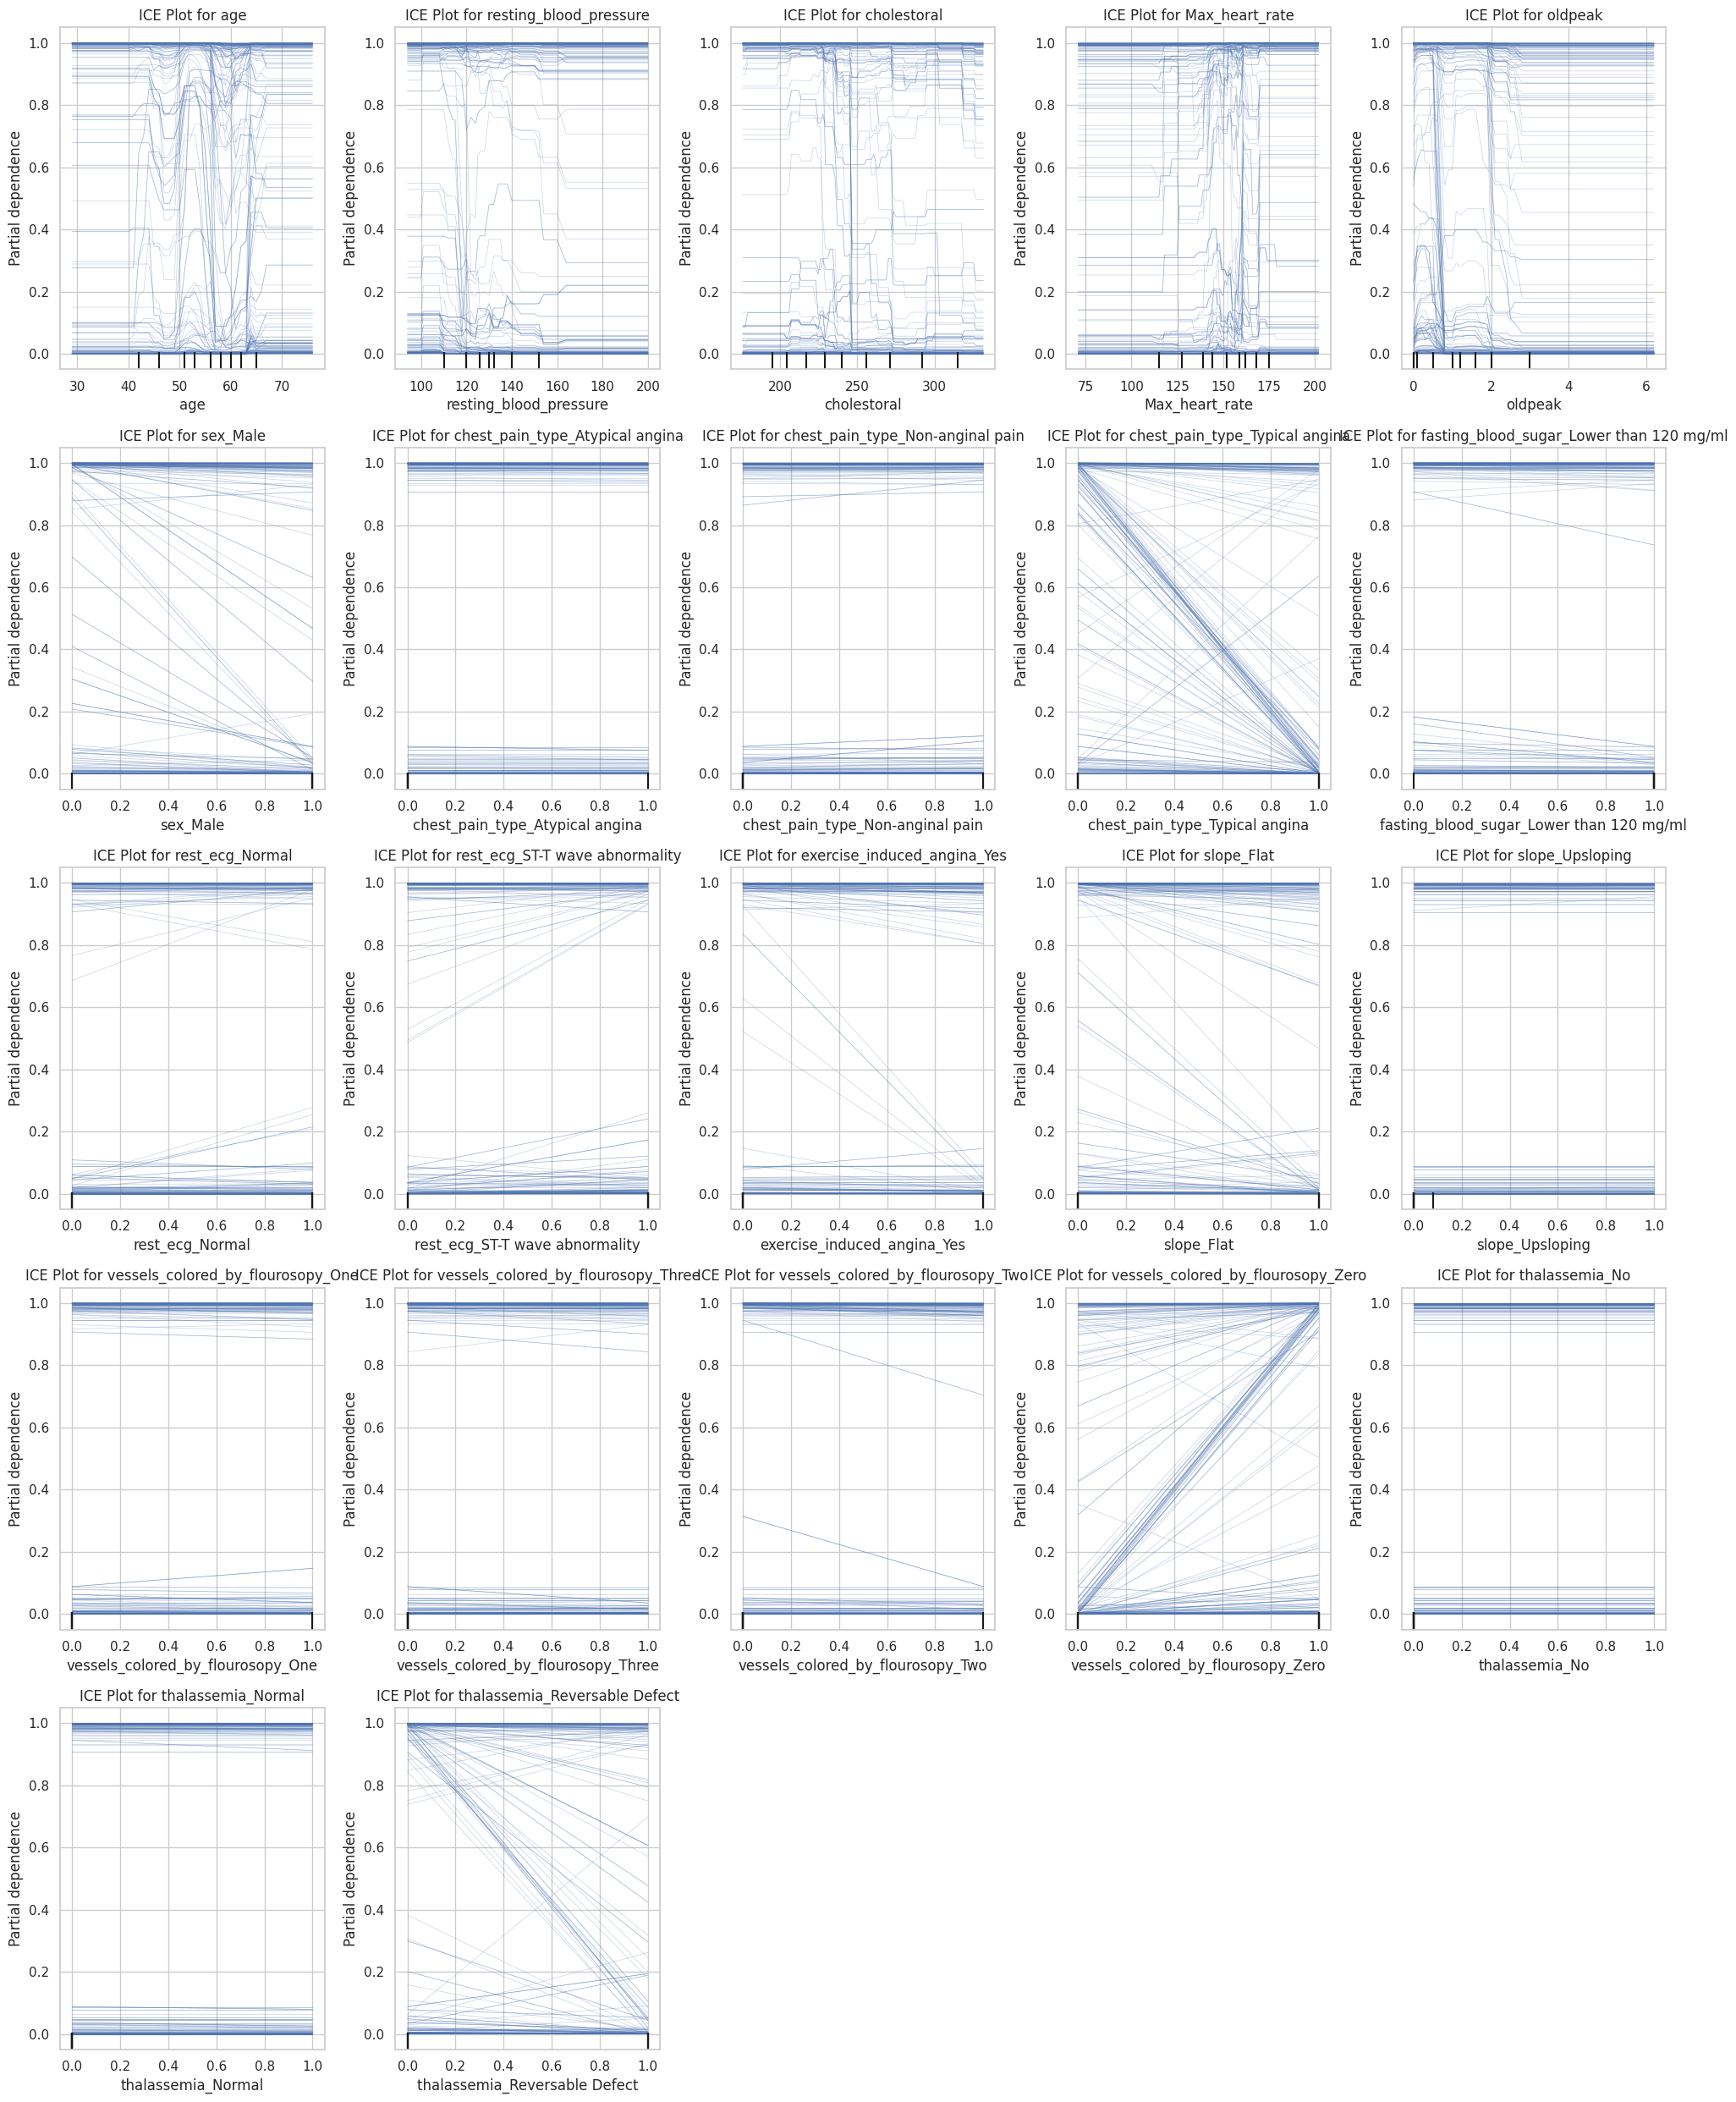

In [56]:
# List of all features in the dataset
features = X.columns.tolist()

# Set number of rows and columns for subplots
n_features = len(features)
n_cols = 5  # Set to 5 plots per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots for ICE plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Adjust figure size

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot ICE for each feature in a loop
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, [X.columns.get_loc(feature)], kind='individual', ax=axs[i]
    )
    axs[i].set_title(f'ICE Plot for {feature}')

# Remove any empty subplots if the number of features isn't a perfect multiple of n_cols
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

ICE Plot and PDP overlayed on Top

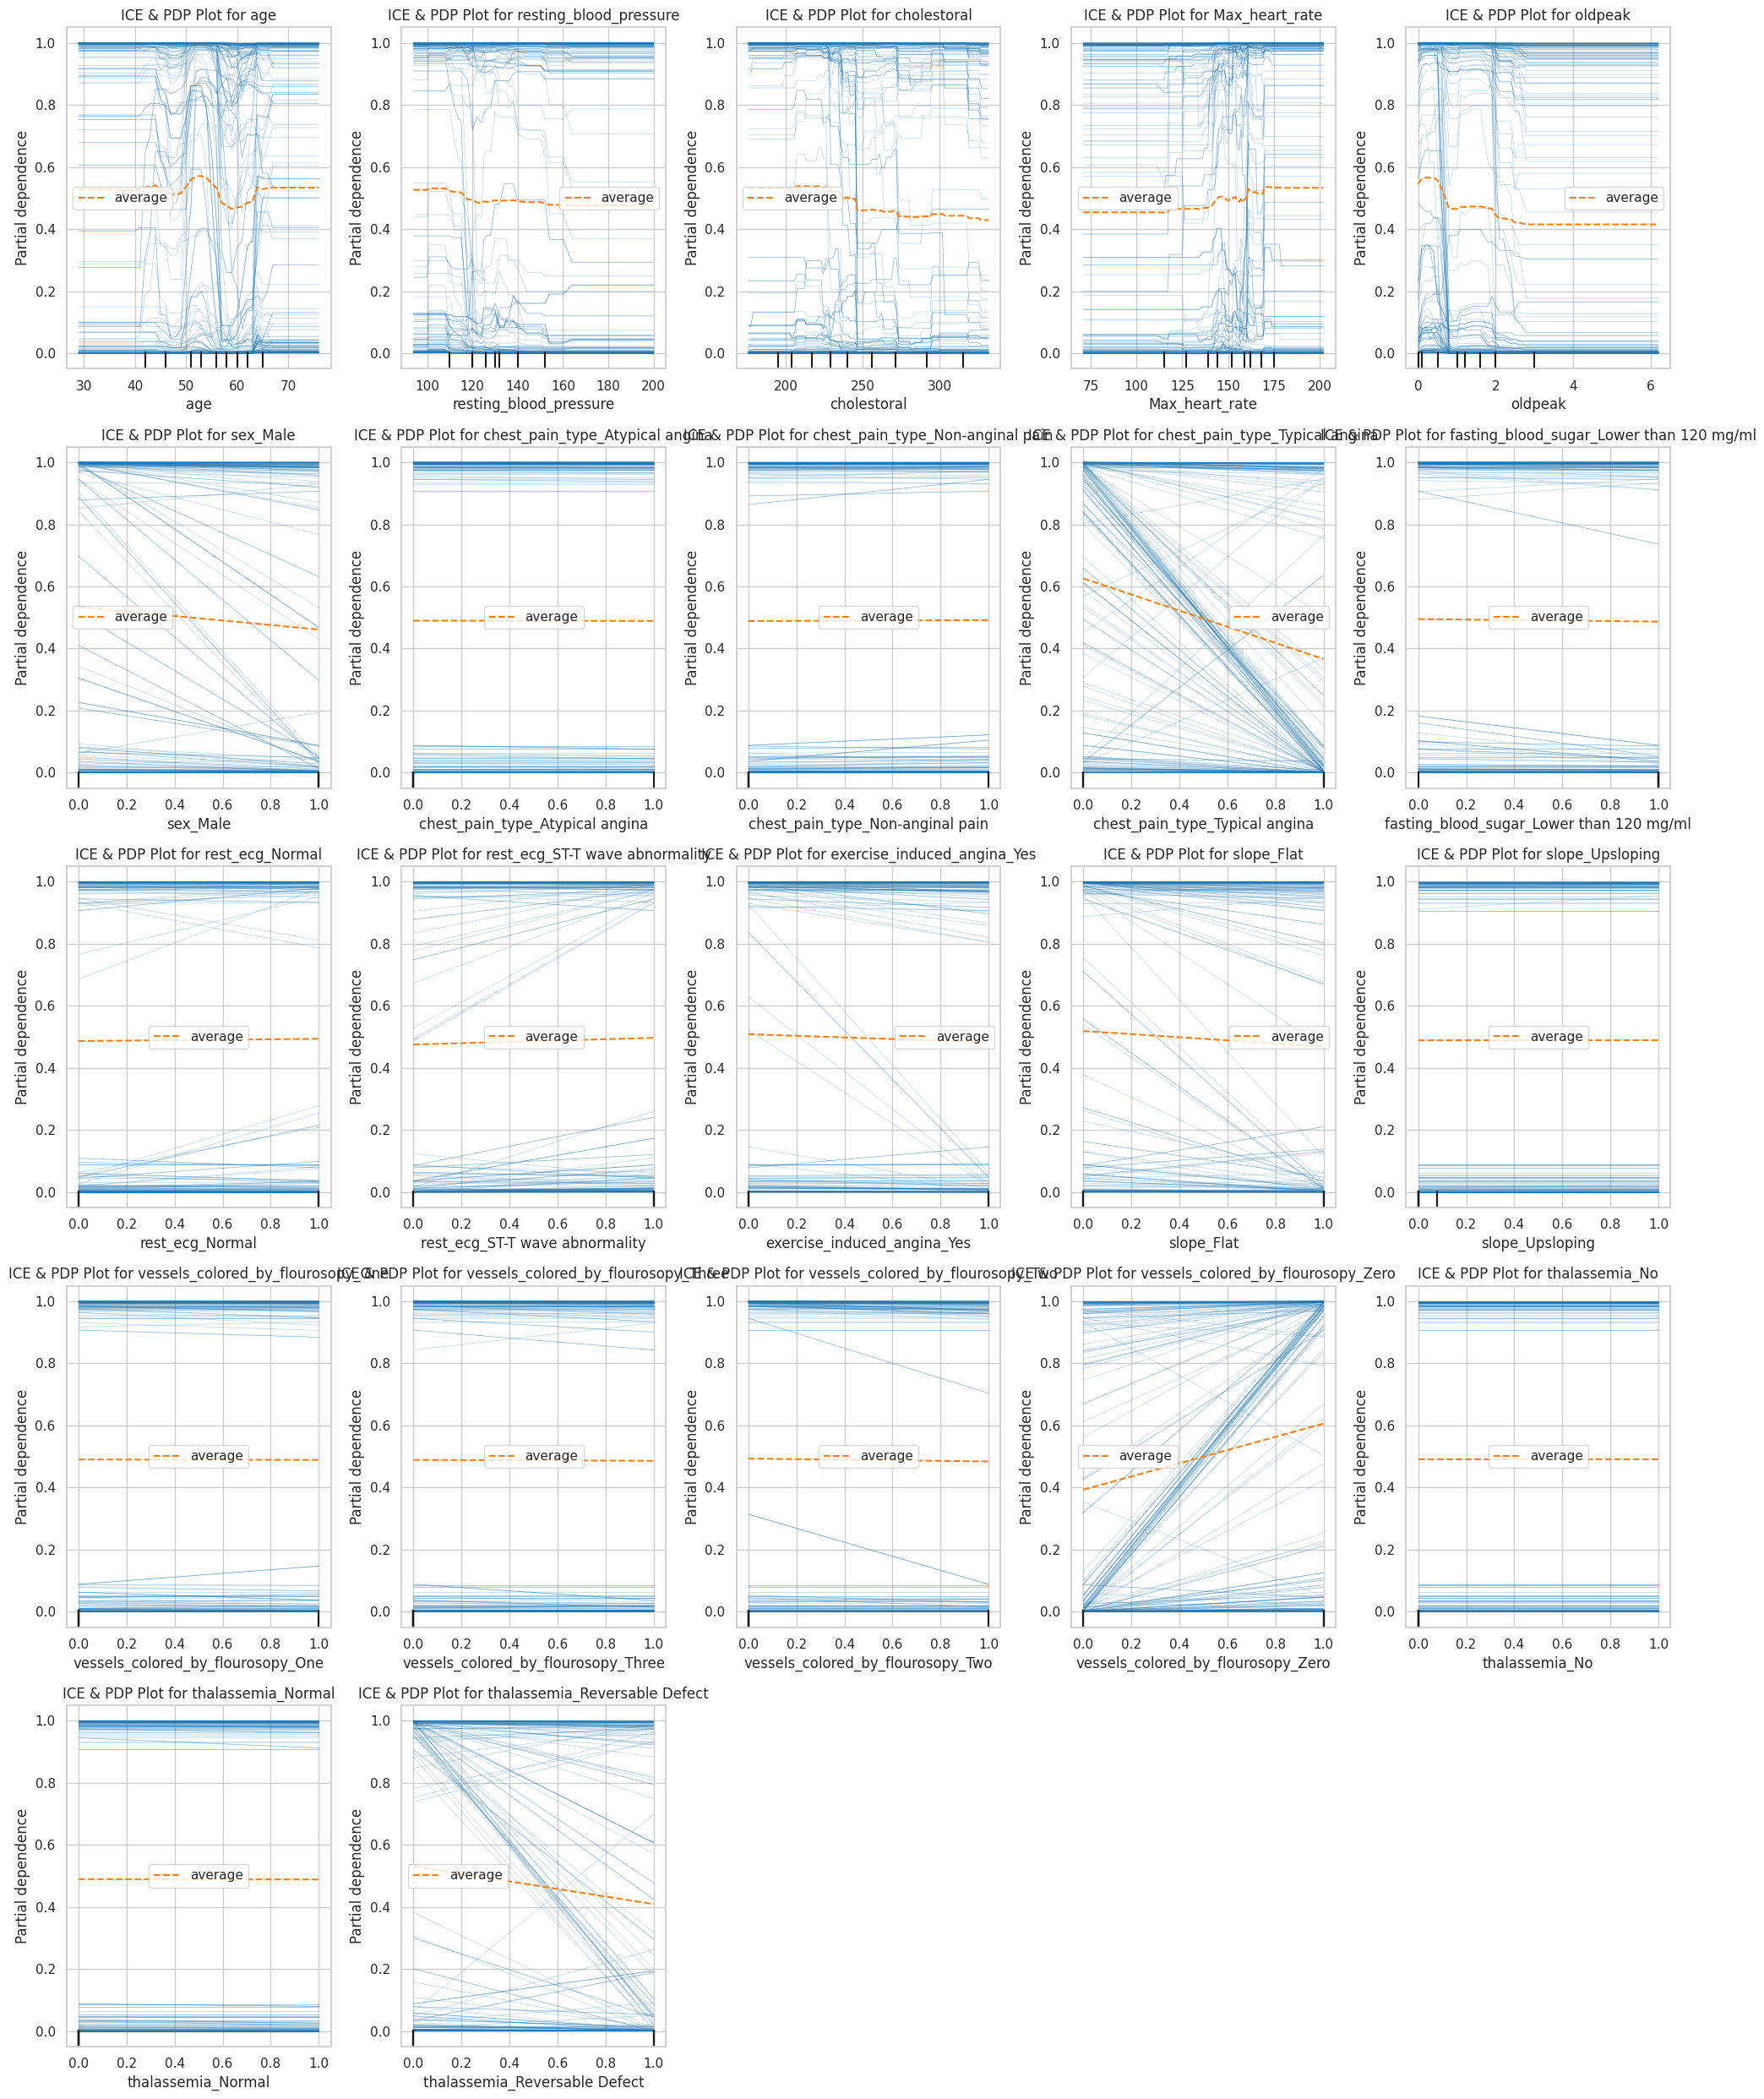

In [57]:
# List of all features in the dataset
features = X.columns.tolist()

# Set number of rows and columns for subplots
n_features = len(features)
n_cols = 5  # Set to 5 plots per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots for ICE and PDP plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Adjust figure size

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot ICE and PDP overlaid for each feature in a loop
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, [X.columns.get_loc(feature)], kind='both', ax=axs[i]
    )
    axs[i].set_title(f'ICE & PDP Plot for {feature}')

# Remove any empty subplots if the number of features isn't a perfect multiple of n_cols
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

ICE Plot and PDP overlayed on Top (center the curves at a certain point in the feature and display only the difference in the prediction to this point)

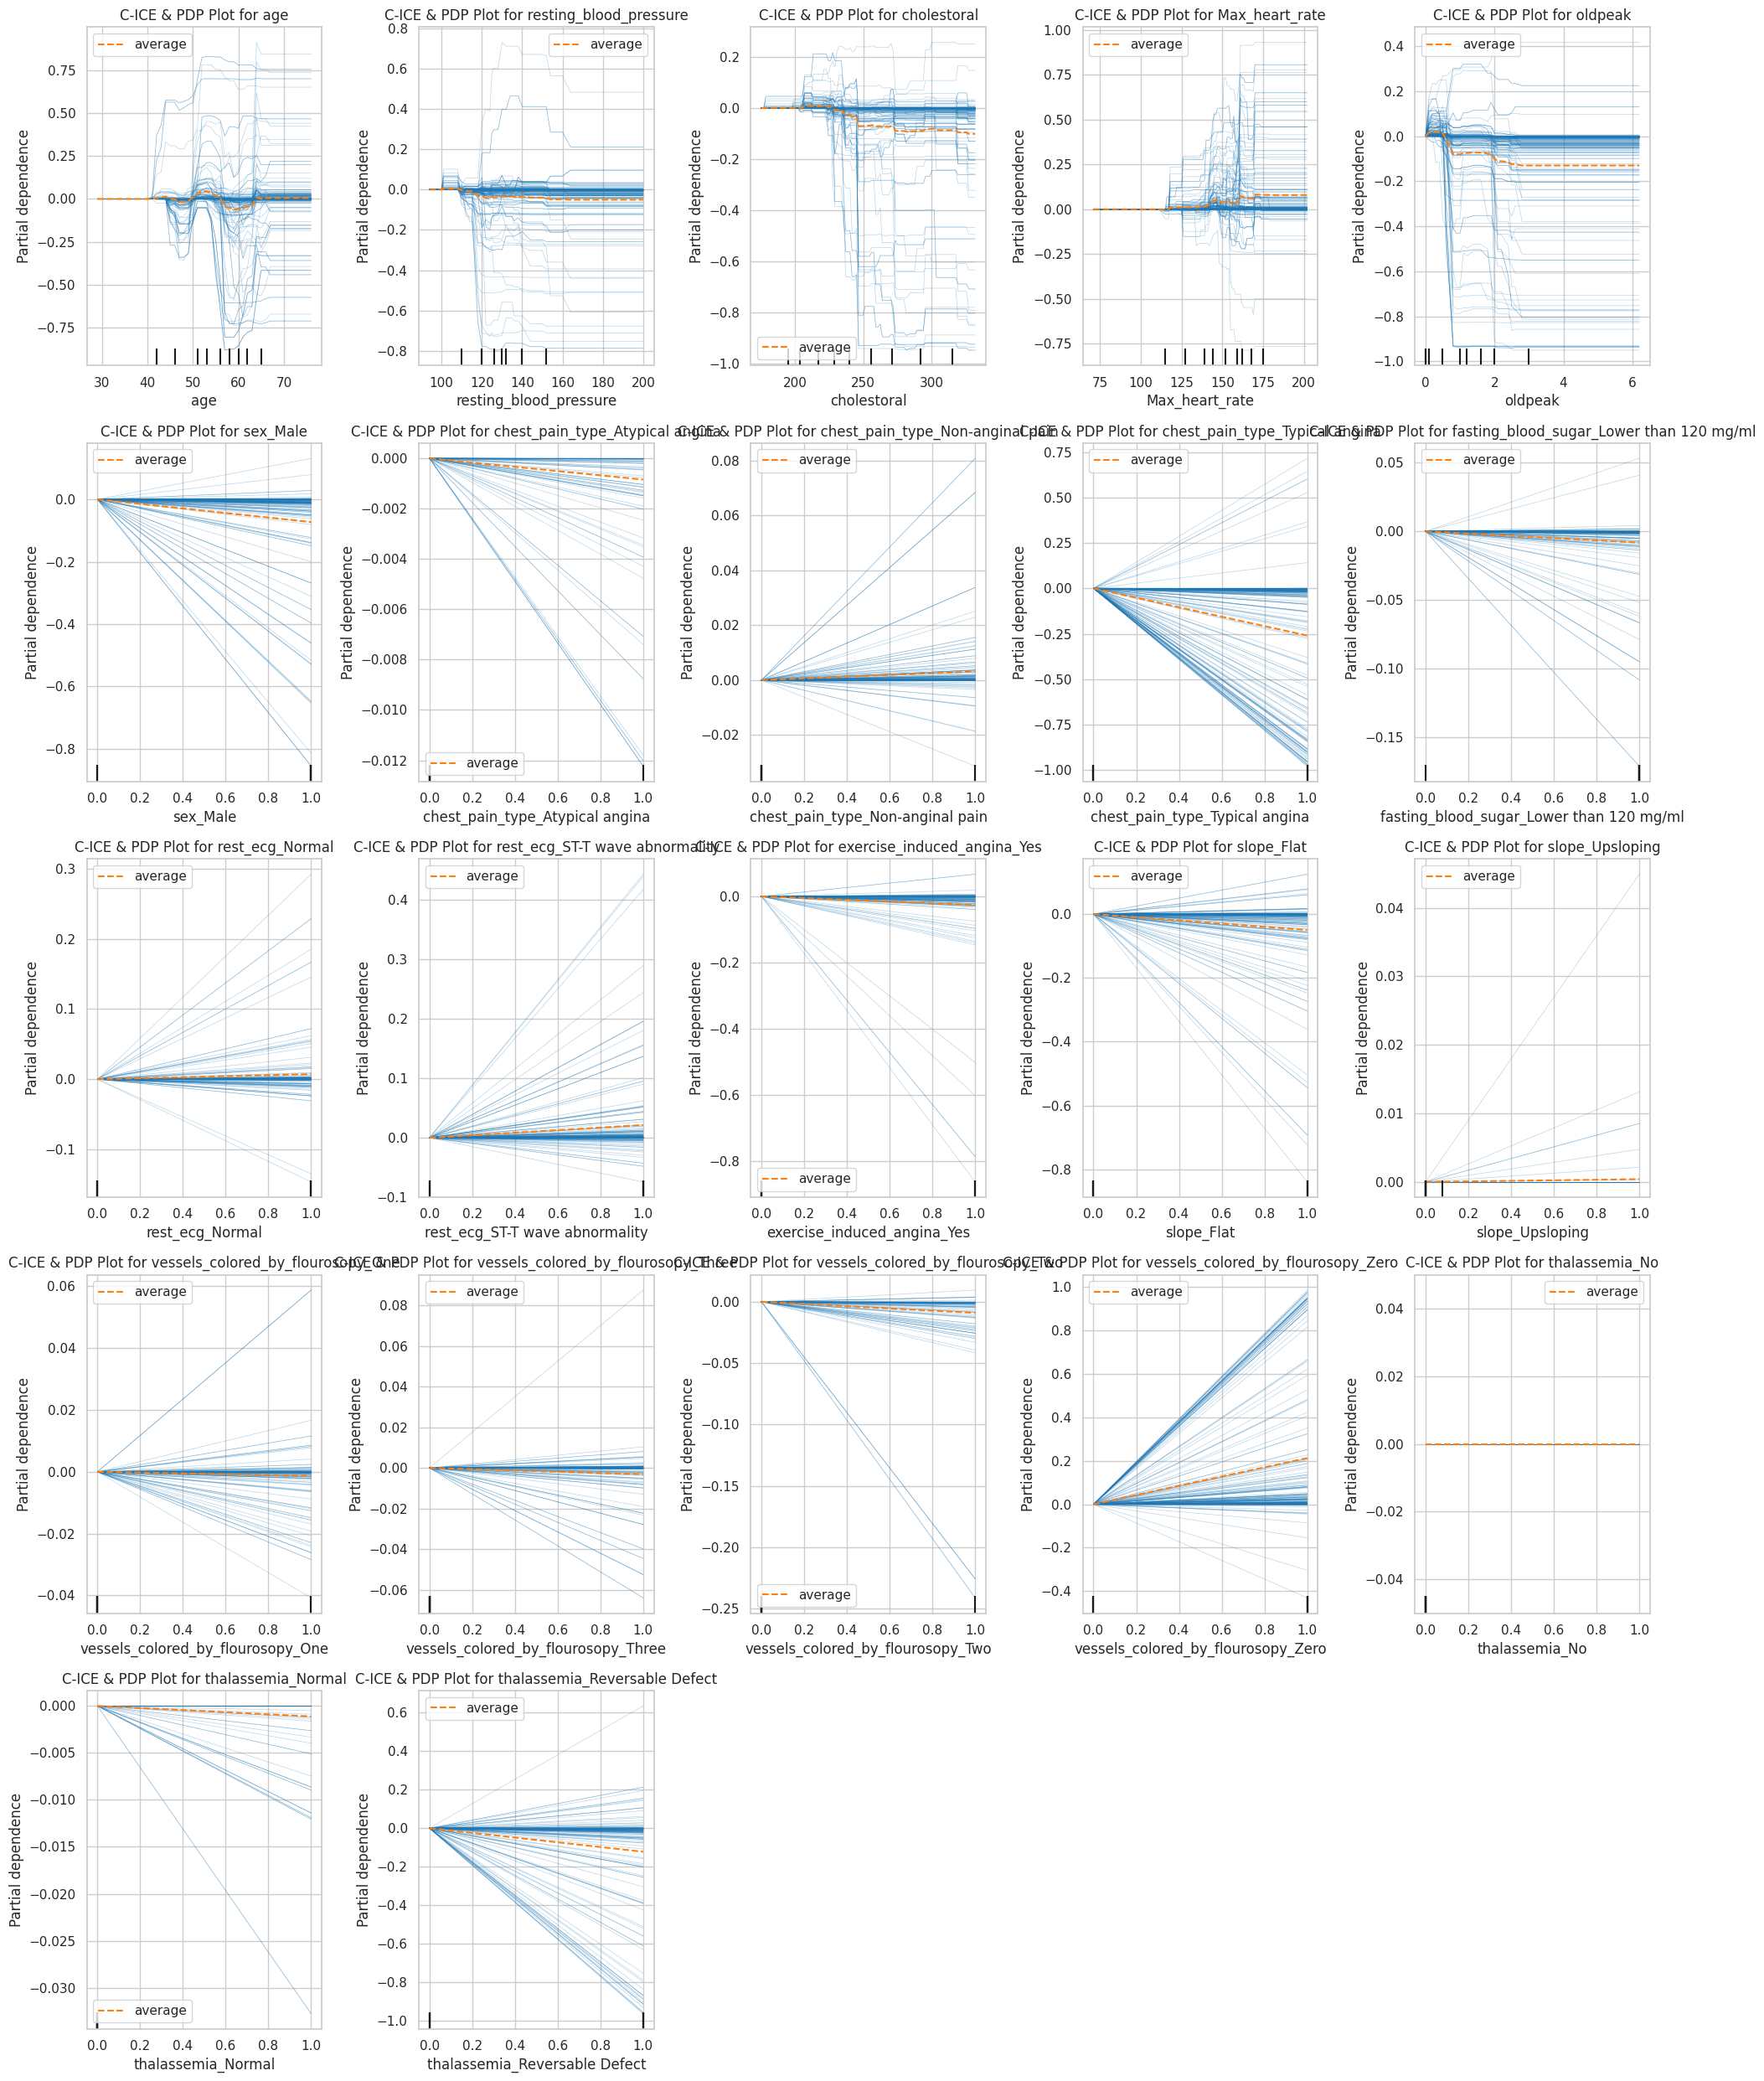

In [58]:
# List of all features in the dataset
features = X.columns.tolist()

# Set number of rows and columns for subplots
n_features = len(features)
n_cols = 5  # Set to 5 plots per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots for C-ICE and PDP plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Adjust figure size

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot C-ICE and PDP for each feature in a loop
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, [X.columns.get_loc(feature)], kind='both', centered=True, ax=axs[i]
    )
    axs[i].set_title(f'C-ICE & PDP Plot for {feature}')

# Remove any empty subplots if the number of features isn't a perfect multiple of n_cols
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### 1D Main Effect ALE Plot

ALE plots provide an interpretable way to visualize how individual features impact model predictions while accounting for feature interactions. Unlike Partial Dependence Plots (PDPs), which assume features are independent, ALE adjusts for feature correlations, making it more reliable in complex models.

**Key Differences Between ALE and PDP**:
- **Feature Correlations**: ALE handles correlated features, offering a more accurate view of feature importance. PDPs assume independence, which can lead to misleading interpretations.
- **Efficiency**: ALE plots are **faster to compute** because they focus on specific intervals, unlike PDPs which average over the entire dataset.

**Pros of ALE**:
- **Handles Correlations**: Unbiased, even with correlated features.
- **Clear Interpretation**: Captures local, incremental effects.
- **Faster Computation**: More efficient than PDPs.

**Cons of ALE**:
- **Discrepancies in Linear Models**: Can differ from linear coefficients when features are highly correlated.
- **More Complex**: Harder to implement and less intuitive than PDPs.


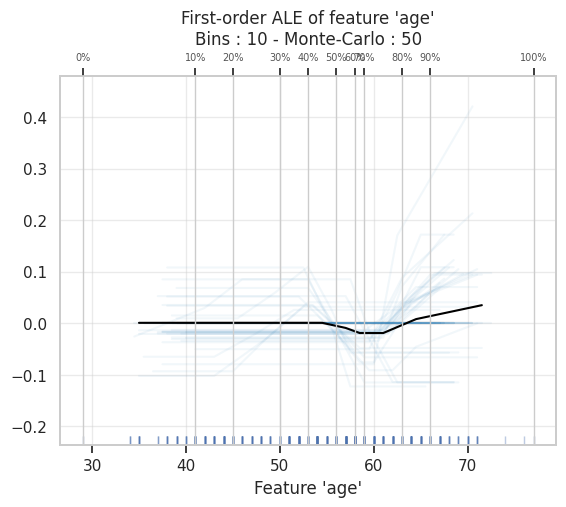

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [66]:
# Use default parameters for 1D Main Effect ALE Plot
ale_plot(model, X_train, 'age', monte_carlo=True)

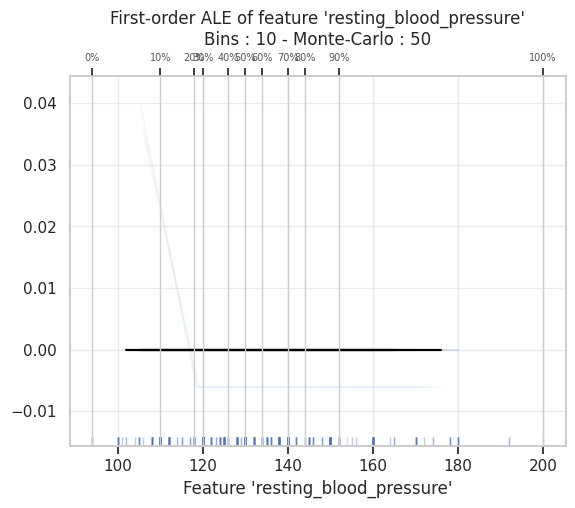

<Axes: title={'center': "First-order ALE of feature 'resting_blood_pressure'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'resting_blood_pressure'">

In [67]:
ale_plot(model, X_train, 'resting_blood_pressure', monte_carlo=True)

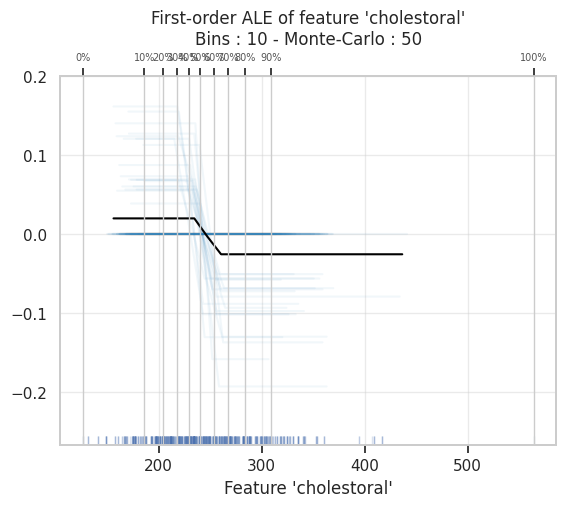

<Axes: title={'center': "First-order ALE of feature 'cholestoral'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'cholestoral'">

In [68]:
ale_plot(model, X_train, 'cholestoral', monte_carlo=True)

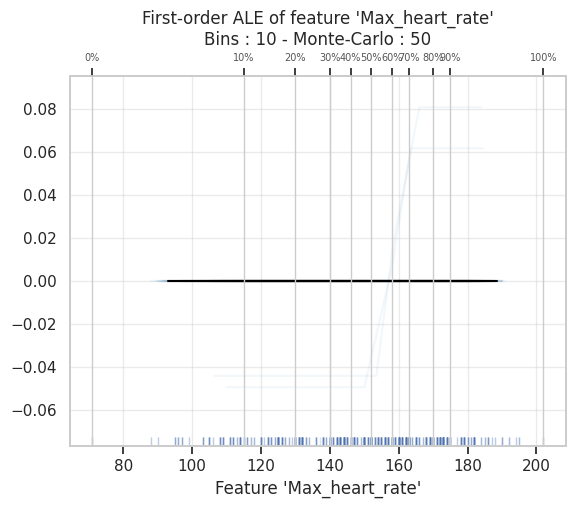

<Axes: title={'center': "First-order ALE of feature 'Max_heart_rate'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Max_heart_rate'">

In [69]:
ale_plot(model, X_train, 'Max_heart_rate', monte_carlo=True)

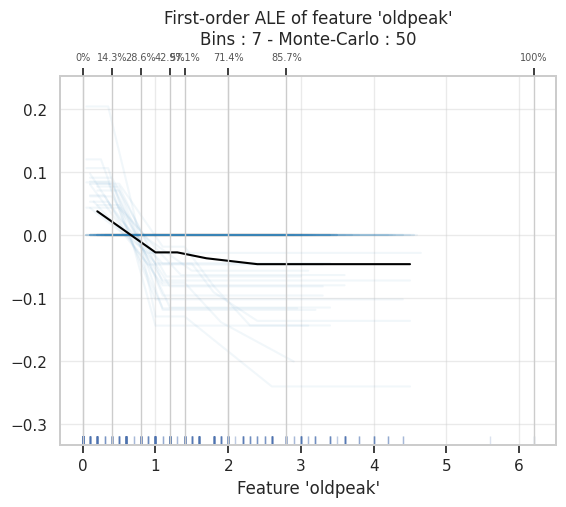

<Axes: title={'center': "First-order ALE of feature 'oldpeak'\nBins : 7 - Monte-Carlo : 50"}, xlabel="Feature 'oldpeak'">

In [70]:
ale_plot(model, X_train, 'oldpeak', monte_carlo=True)

### Change hyperparameters for 1D Main Effect ALE Plot

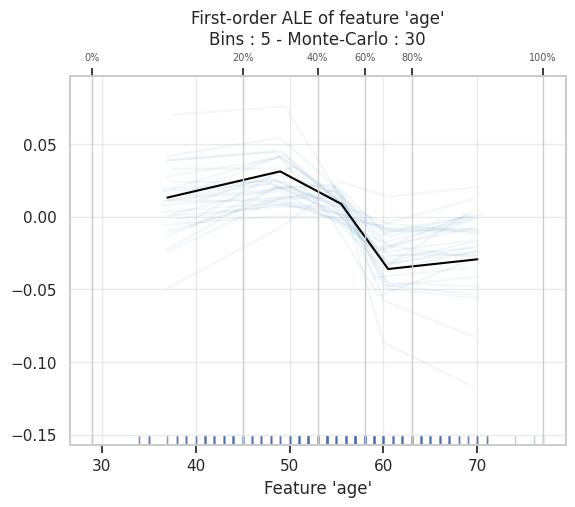

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'age'">

In [71]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

#### Compare PDP to ALE for Age

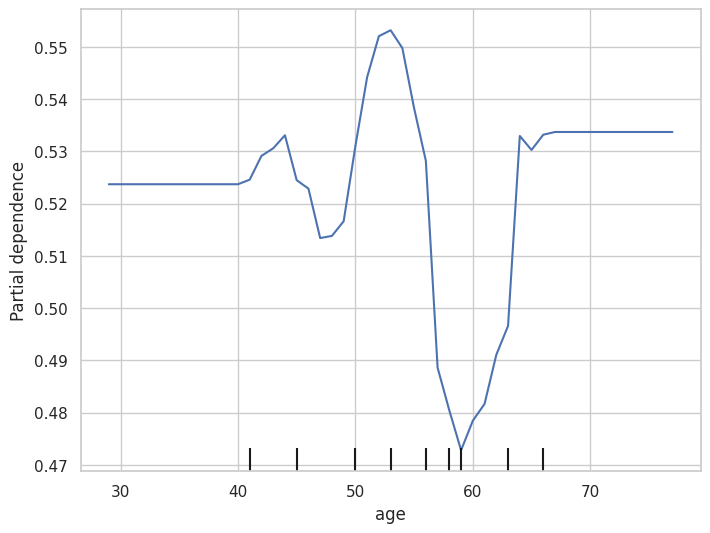

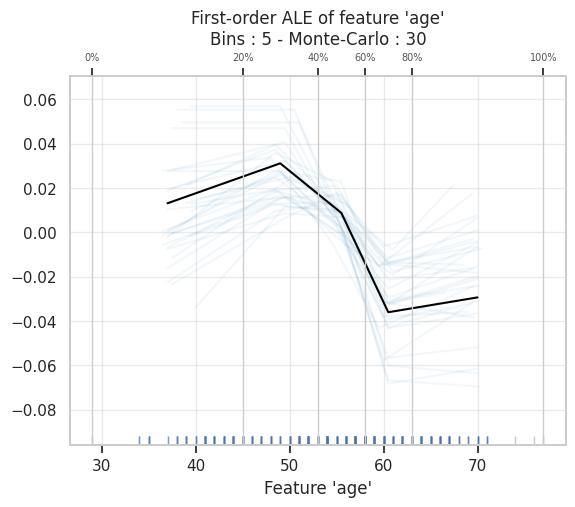

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'age'">

In [81]:
# Generate PDP Plot for 'age'
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PDP for 'age' using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_train, ['age'], kind='average', ax=ax)

# Generate ALE plot for 'age' and capture the data
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)


### **Interpretation of the PDP Plot (First) and ALE Plot (Second) for Age**

#### **1. ALE Plot (Accumulated Local Effects) for Age**:
- **Pattern**: The ALE plot shows a non-linear pattern with clear changes in the trend at specific age ranges:
  - From **age 40 to 50**, the effect on the prediction increases slightly, indicating that in this range, the model predicts a higher risk of heart disease as age increases.
  - From **50 to 60**, there is a **sharp decrease**, meaning the model predicts a lower risk of heart disease as age increases.
  - After **age 60**, the effect stabilizes with a small upward trend, indicating that further increases in age do not significantly affect the predictions.
- **Steeper Curves**:
   - The steepness of the downward curve between 50 and 60 shows that the effect of age in this range has a larger negative impact on heart disease predictions. This implies that the model has learned that individuals between these ages are predicted to be at lower risk as they age
- **Summary of ALE Plot for Age**:
  - **Upward trend (40-50)**: Increasing age slightly increases the likelihood of heart disease, but the effect is mild.
  - **Steep downward trend (50-60)**: Increasing age in this range significantly decreases the likelihood of heart disease, showing a stronger negative impact.
  - **Flat curve (60+)**: After 60, age has little to no further impact on predictions, as indicated by the flat curve.

#### **2. PDP Plot (Partial Dependence Plot) for Age**:
- **Pattern**: The PDP plot also shows a non-linear pattern, but with more extreme fluctuations:
  - Between **age 40 and 50**, there is a slight upward trend, but then the curve shows **sharp increases** and **sharp drops** from **50 to 60**.
  - After age **60**, the effect stabilizes, but the trend seen in the PDP is more volatile compared to the ALE plot.

---

#### **Comparison and Key Differences Between ALE and PDP**:

1. **Handling of Feature Correlations**:
   - **ALE**: Accounts better for **feature interactions** and correlations. It shows how the model’s predictions change while considering the interactions between features. This makes ALE more robust when features like age are correlated with others (as evidenced by the high VIF score for age).
   - **PDP**: Assumes that features are independent, which can lead to **misleading trends** if the feature (like age) is correlated with other features. In this case, the sharp fluctuations seen in the PDP plot for age may be due to this assumption of independence.

3. **Smoothing of Predictions**:
   - **ALE Plot**: The trends in the ALE plot are smoother and more intuitive because it corrects for the correlation between features. It shows a more realistic progression, where heart disease risk changes incrementally with age.
   - **PDP Plot**: The PDP plot is more **volatile**, with sharp peaks and valleys, which could be masking the true relationship between age and heart disease due to averaging effects over the whole dataset.

4. **Interpretation of Changes**:
   - In the **ALE plot**, we can observe a more gradual increase and decrease in risk, with the sharp drop between ages 50-60 showing a clear pattern. The **PDP plot**, however, shows larger fluctuations between these same age ranges, making it harder to discern an overall trend.

---

#### **Conclusion**:
- The **ALE plot** provides a more nuanced and accurate view of how **age** affects heart disease predictions. It avoids the distortions caused by feature correlations, resulting in smoother and more interpretable trends.
- The **PDP plot**, while showing the overall trend, exaggerates the fluctuations in risk due to its assumption of independence, potentially leading to misleading interpretations, especially in cases where age interacts with other features.


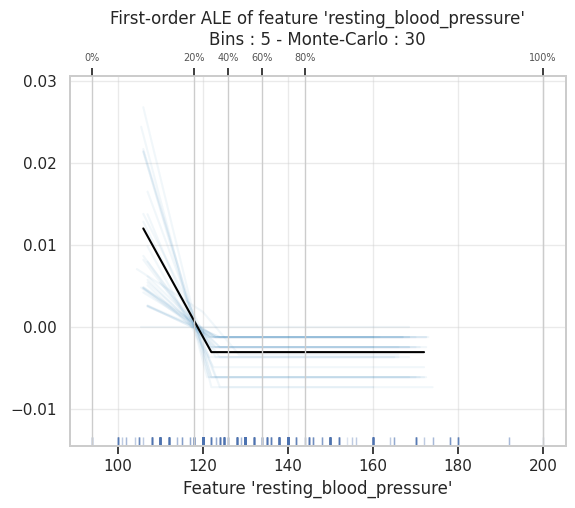

<Axes: title={'center': "First-order ALE of feature 'resting_blood_pressure'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'resting_blood_pressure'">

In [72]:
ale_plot(
    model,
    X_train,
    "resting_blood_pressure",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

Compare PDP to ALE for Resting Blood Pressure

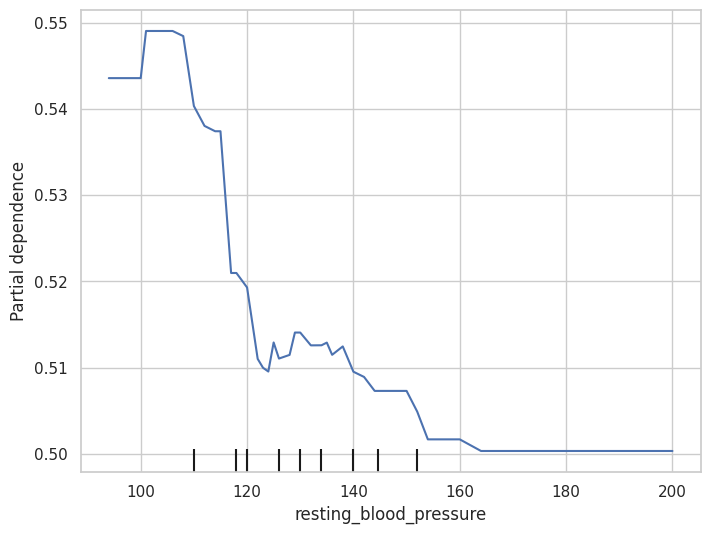

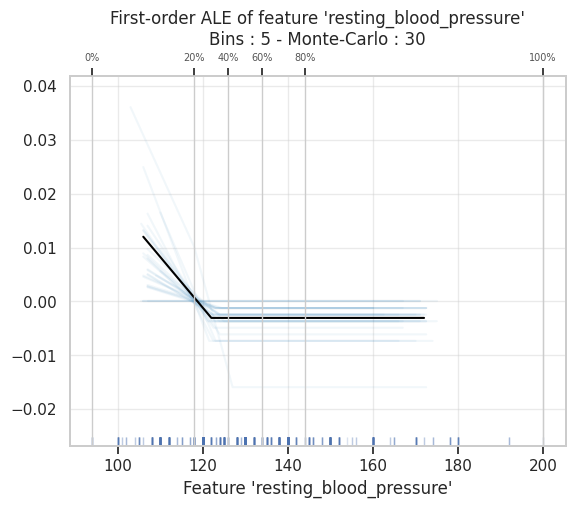

<Axes: title={'center': "First-order ALE of feature 'resting_blood_pressure'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'resting_blood_pressure'">

In [82]:
# Generate PDP Plot for 'resting_blood_pressure'
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PDP for 'resting_blood_pressure' using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_train, ['resting_blood_pressure'], kind='average', ax=ax)

# Generate ALE plot for 'resting_blood_pressure' and capture the data
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "resting_blood_pressure",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

### **Comparison of PDP (First) and ALE (Second) for Resting Blood Pressure**

#### **1. ALE Plot (Accumulated Local Effects) for Resting Blood Pressure**:
- **Interpretation**:
  - From **100 to 120**, the ALE curve shows a **sharp drop**, indicating that increasing blood pressure in this range significantly **reduces the predicted risk** of heart disease.
  - After **120**, the ALE plot flattens, suggesting that increases in blood pressure beyond 120 have **minimal impact** on the prediction.
  
- **Insights**:
  - The sharp downward trend between 100 and 120 shows that the model predicts a lower risk of heart disease as blood pressure increases in this range.
  - The **flat curve** after 120 suggests that blood pressure values beyond this point have little additional effect on the prediction, meaning that the model does not consider these values important in determining heart disease risk.

---

#### **2. PDP Plot (Partial Dependence Plot) for Resting Blood Pressure**:
  
- **Interpretation**:
  - The PDP shows a **sharp and turbulated decrease** in the predicted likelihood of heart disease as resting blood pressure increases from **100 to 160**, with the most significant decrease occurring between 100 and 120.
  - After **120**, the plot continues to decrease slightly but at a much slower pace until **160**, after which the curve flattens, similar to the ALE plot.

- **Insights**:
  - The PDP indicates that **higher blood pressure is associated with a lower average prediction of heart disease**, but the curve is more fluctuated than the ALE plot in the 100–120 range.

---

### **Key Differences Between ALE and PDP for Resting Blood Pressure**:


1. **Fluctuations**:
   - The **PDP** shows some minor **fluctuations** between 120 and 160, likely caused by feature interactions or averaging effects. These fluctuations are not seen in the **ALE plot**, which shows a smoother and more consistent relationship between resting blood pressure and the prediction.

3. **Handling of Feature Correlations**:
   - **ALE** adjusts for feature correlations and interactions, meaning it can more accurately capture how the model's predictions are influenced by resting blood pressure in specific ranges. The **sharp drop** from 100 to 120 shows that in this range, the feature has a much larger effect on reducing the risk of heart disease.
   - **PDP**, on the other hand, assumes feature independence, which can lead to misleading trends if there are correlations between features. The **fluctuated downward trend** seen in the PDP plot may be hiding complex interactions that the ALE plot captures more effectively.



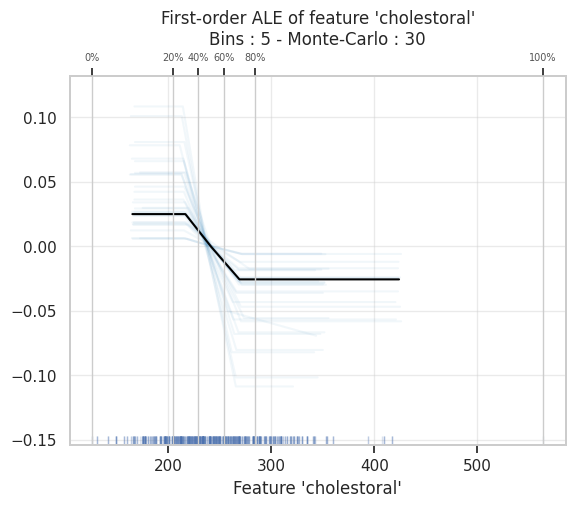

<Axes: title={'center': "First-order ALE of feature 'cholestoral'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'cholestoral'">

In [73]:
ale_plot(
    model,
    X_train,
    "cholestoral",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

Compare PDP to ALE for Cholestoral

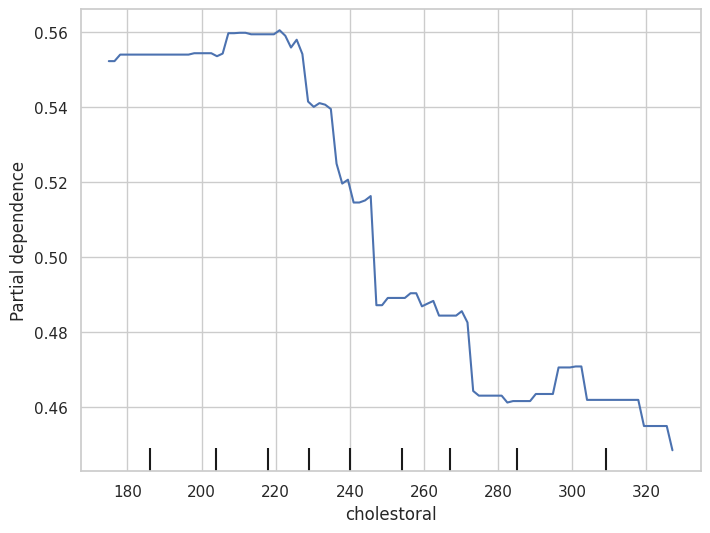

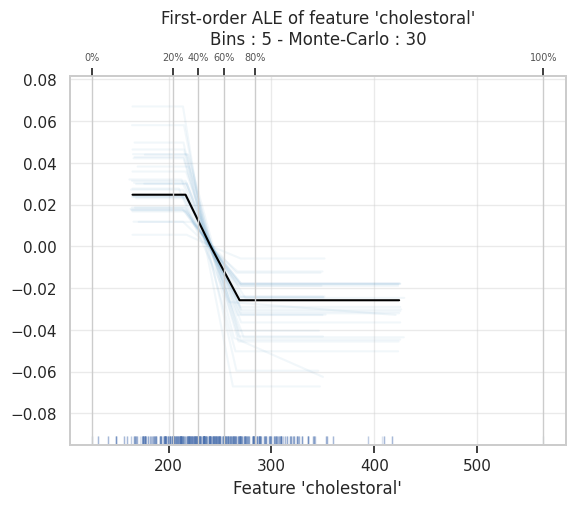

<Axes: title={'center': "First-order ALE of feature 'cholestoral'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'cholestoral'">

In [83]:
# Generate PDP Plot for 'Cholestoral'
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PDP for 'Cholestoral' using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_train, ['cholestoral'], kind='average', ax=ax)

# Generate ALE plot for 'Cholestoral' and capture the data
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "cholestoral",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

### **Comparison of ALE and PDP for Cholesterol**

#### **1. ALE Plot (Accumulated Local Effects) for Cholesterol**:

- **Insights**:
  - The **sharp decline** in the ALE plot from 220 to 260 suggests that the model considers cholesterol in this range to have a significant negative effect on heart disease risk.
  - The **flat curve** after 260 suggests that higher cholesterol values beyond this range do not significantly change the predictions.

---

#### **2. PDP Plot (Partial Dependence Plot) for Cholesterol**:

- **Insights**:
  - The **sharp decline** between 220 and 260 aligns with the ALE plot, indicating that increasing cholesterol levels in this range significantly decreases heart disease risk.
  - The **fluctuations** seen in the PDP beyond 240 may be due to the correlation effects.

---

### **Key Differences Between ALE and PDP for Cholesterol**:

1. **Fluctuations**:
   - The **PDP plot** shows **fluctuations** in the cholesterol range beyond 240, indicating variability in how cholesterol affects different observations.
   - The **ALE plot** does not show these fluctuations, resulting in a more consistent and smoother curve.

3. **Handling of Feature Correlations**:
   - **ALE** accounts for interactions and correlations between cholesterol and other features. This allows it to isolate the true effect of cholesterol, as seen by the smooth transitions and sharp declines in key intervals (e.g., between 220 and 260).
   - **PDP** assumes feature independence, which can lead to some misleading trends when features are correlated. This may explain the **fluctuations** in the PDP plot, which could be a result of cholesterol interacting with other features.


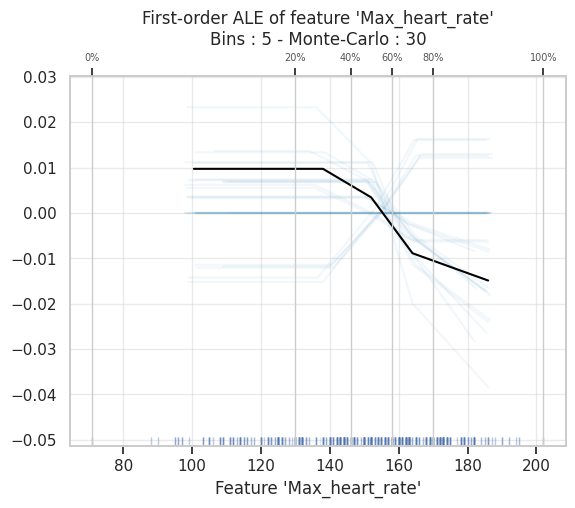

<Axes: title={'center': "First-order ALE of feature 'Max_heart_rate'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Max_heart_rate'">

In [74]:
ale_plot(
    model,
    X_train,
    "Max_heart_rate",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

Compare PDP to ALE for Max_heart_rate

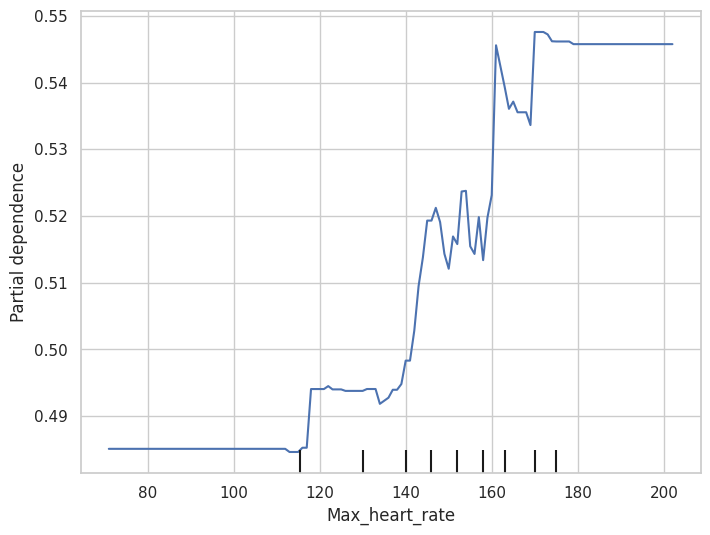

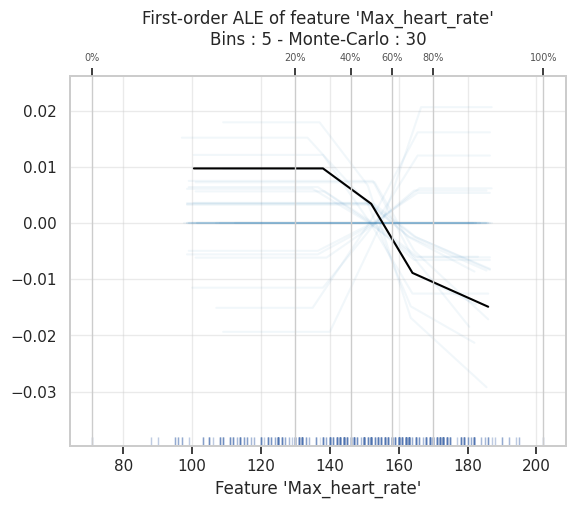

<Axes: title={'center': "First-order ALE of feature 'Max_heart_rate'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Max_heart_rate'">

In [84]:
# Generate PDP Plot for 'Max_heart_rate'
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PDP for 'Max_heart_rate' using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_train, ['Max_heart_rate'], kind='average', ax=ax)

# Generate ALE plot for 'Max_heart_rate' and capture the data
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "Max_heart_rate",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

### **Analysis of Max Heart Rate: ALE vs. PDP**

#### **1. ALE Plot (Accumulated Local Effects) for Max Heart Rate**:
  
- **Interpretation**:
  - The ALE plot shows a **flat trend** between 100 and 140, indicating that in this range, changes in max heart rate have little impact on predictions.
  - After **140**, the ALE plot shows a **downward trend**, suggesting that increasing max heart rate beyond this value significantly **decreases** the likelihood of heart disease.
  - As the max heart rate increases from 160 to 200, the negative effect becomes stronger, implying that higher heart rates lower the model's predictions for heart disease.

- **Insights**:
  - The ALE plot reveals that **higher max heart rate is associated with a decreased risk** of heart disease, especially beyond 140.
  - This effect makes sense as a higher max heart rate is often linked to better cardiovascular fitness, which is generally protective against heart disease. The ALE plot correctly adjusts for interactions with other features, presenting a clearer effect of max heart rate.

---

#### **2. PDP Plot (Partial Dependence Plot) for Max Heart Rate**:
  
- **Interpretation**:
  - The PDP plot shows a **flat trend** from 80 to 120, indicating that max heart rate in this range has little effect on the predictions.
  - After **120**, there is a **sharp upward trend**, with the predictions for heart disease **increasing** as max heart rate rises beyond this point.
  - The most pronounced increase is seen between **160 and 180**, where the model predicts a higher likelihood of heart disease for individuals with higher max heart rates.

- **Insights**:
  - According to the PDP, **higher max heart rate is associated with an increased risk** of heart disease, which is counterintuitive as max heart rate typically reflects good cardiovascular health.
  - The **upward trend** seen in the PDP may suggest that the model, on average, predicts a higher risk of heart disease for individuals with higher heart rates. However, this is likely misleading due to the assumption of feature independence.

---

### **Key Differences and Why They Occur**:

1. **Contradictory Trends**:
   - The **PDP** shows an **upward trend**, indicating that as max heart rate increases, the risk of heart disease also increases.
   - In contrast, the **ALE plot** shows a **downward trend**, where higher max heart rates are associated with a **lower risk** of heart disease.

2. **Handling of Correlations**:
   - **ALE** addresses feature correlations, meaning it can better isolate the true impact of max heart rate on predictions while accounting for interactions with other features (such as age, fitness level, or blood pressure). This leads to the conclusion that **higher heart rate decreases risk**, as would be expected for individuals with better cardiovascular health.
   - **PDP**, however, **assumes feature independence**, which can lead to misleading trends when features are correlated. Max heart rate is likely correlated with other important health indicators (e.g., age, blood pressure), and this correlation may cause the **upward trend** seen in the PDP. The PDP doesn't correct for these correlations, potentially exaggerating or misinterpreting the effect of max heart rate.

In [75]:
ale_plot(
    model,
    X_train,
    "oldpeak",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

<Axes: title={'center': "First-order ALE of feature 'oldpeak'\nBins : 4 - Monte-Carlo : 30"}, xlabel="Feature 'oldpeak'">

Compare PDP to ALE for oldpeak


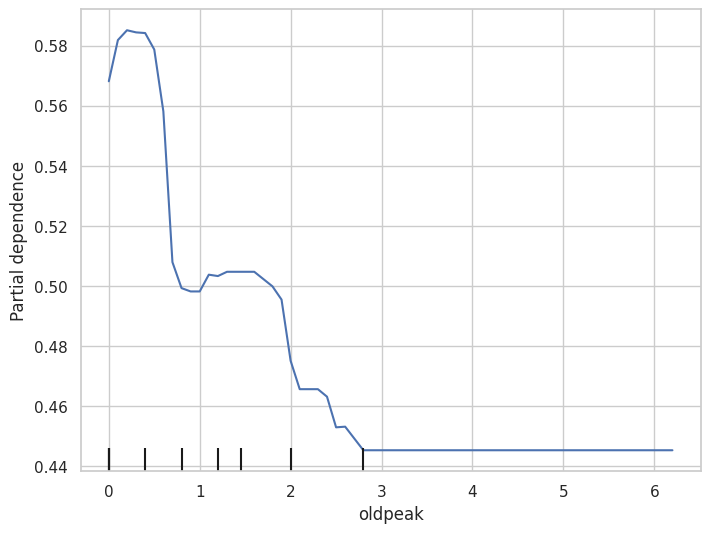

<Axes: title={'center': "First-order ALE of feature 'oldpeak'\nBins : 4 - Monte-Carlo : 30"}, xlabel="Feature 'oldpeak'">

In [85]:
# Generate PDP Plot for 'oldpeak'
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PDP for 'oldpeak' using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_train, ['oldpeak'], kind='average', ax=ax)

# Generate ALE plot for 'oldpeak' and capture the data
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "oldpeak",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

### **Comparison of ALE and PDP for Oldpeak**

#### **1. ALE Plot (Accumulated Local Effects) for Oldpeak**:
  
- **Interpretation**:
  - The ALE plot shows a **sharp downward slope** from **0 to 1.5**, indicating that an increase in Oldpeak within this range significantly **reduces the likelihood** of heart disease.
  - After **1.5**, the curve flattens, suggesting that Oldpeak values beyond this point have minimal impact on predictions.
  
- **Insights**:
  - The **sharp decrease** in predictions with rising Oldpeak values at the lower end (from 0 to 2) suggests that the model predicts a **lower likelihood of heart disease** as Oldpeak increases.
  - The **flat trend** after 2 indicates that higher Oldpeak values no longer significantly influence the prediction, meaning that the model does not consider further increases in Oldpeak after this point as relevant.

---

#### **2. PDP Plot (Partial Dependence Plot) for Oldpeak**:
- **Interpretation**:
  - The PDP plot shows a **sharp but fluctuated downward trend** from **0 to 2**, where the predicted likelihood of heart disease **decreases** significantly as Oldpeak increases.
  - Beyond **2**, the plot shows further drops in prediction, but at a much slower rate, eventually flattening after **3**.

- **Insights**:
  - The PDP suggests that increasing Oldpeak is associated with a **lower risk** of heart disease, particularly between 0 and 2.
  - The **flatter trend** beyond 2 is consistent with the ALE plot, indicating that after a certain point, Oldpeak does not substantially affect predictions.

---

### **Key Differences and Similarities**:

1. **Similar Trends**:
   - Both the **ALE** and **PDP** plots show a **sharp decline** in predictions as Oldpeak increases from **0 to 2**, indicating that the model predicts a **lower likelihood of heart disease** with increasing Oldpeak values in this range.
   - After **2**, both plots show a **flatter trend**, suggesting that Oldpeak values beyond this point do not significantly impact the model's predictions.

2. **Handling of Correlations**:
   - **ALE** accounts for feature correlations, allowing it to better capture the **local effect** of Oldpeak on predictions while adjusting for potential interactions with other features. This explains why the ALE plot shows a smoother, more consistent downward trend without excessive fluctuations.
   - **PDP**, on the other hand, assumes feature independence, which may lead to **slight fluctuations** in the prediction as seen between 1 and 2 in the PDP plot. However, in this case, the overall trends are similar because the PDP’s assumption of independence has minimal impact.

3. **Fluctuations**:
   - The **PDP plot** shows some **minor fluctuations** between Oldpeak values of **1 and 2**, which may be due to the interactions with other features. These fluctuations are smoothed out in the **ALE plot**, which presents a more consistent trend.
